### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS, ROUND_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

### Read Data

In [7]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train.parquet", replace_negative_one=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test.parquet", replace_negative_one=True)

Shape of data: (5531451, 190)
Shape of data: (11363762, 190)
CPU times: user 47.1 s, sys: 1min 6s, total: 1min 53s
Wall time: 56.7 s


In [8]:
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")

In [9]:
%%time
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 6.68 s, sys: 11.7 s, total: 18.4 s
Wall time: 23.9 s


In [10]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


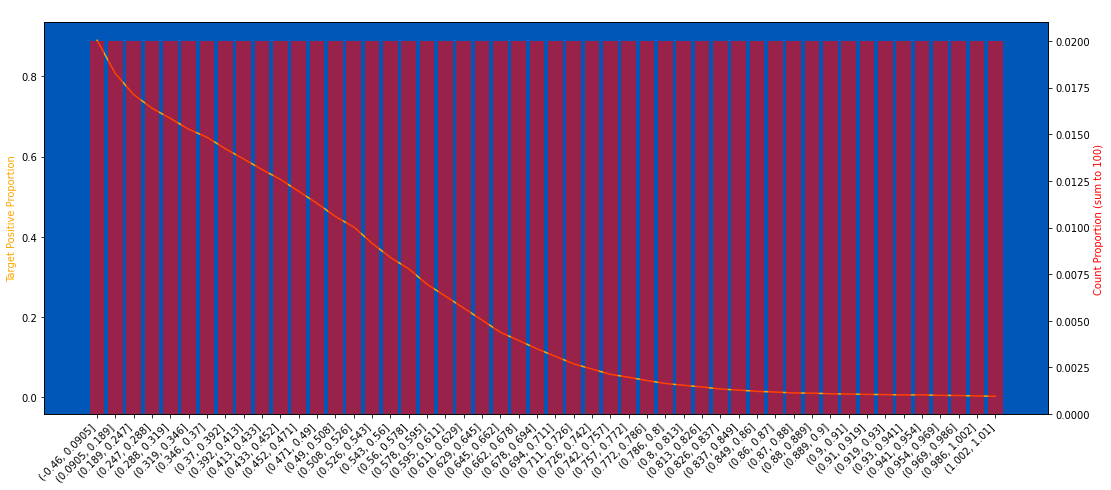

In [11]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [12]:
train["P_2"] = train["P_2"].round(2)
test["P_2"] = test["P_2"].round(2)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


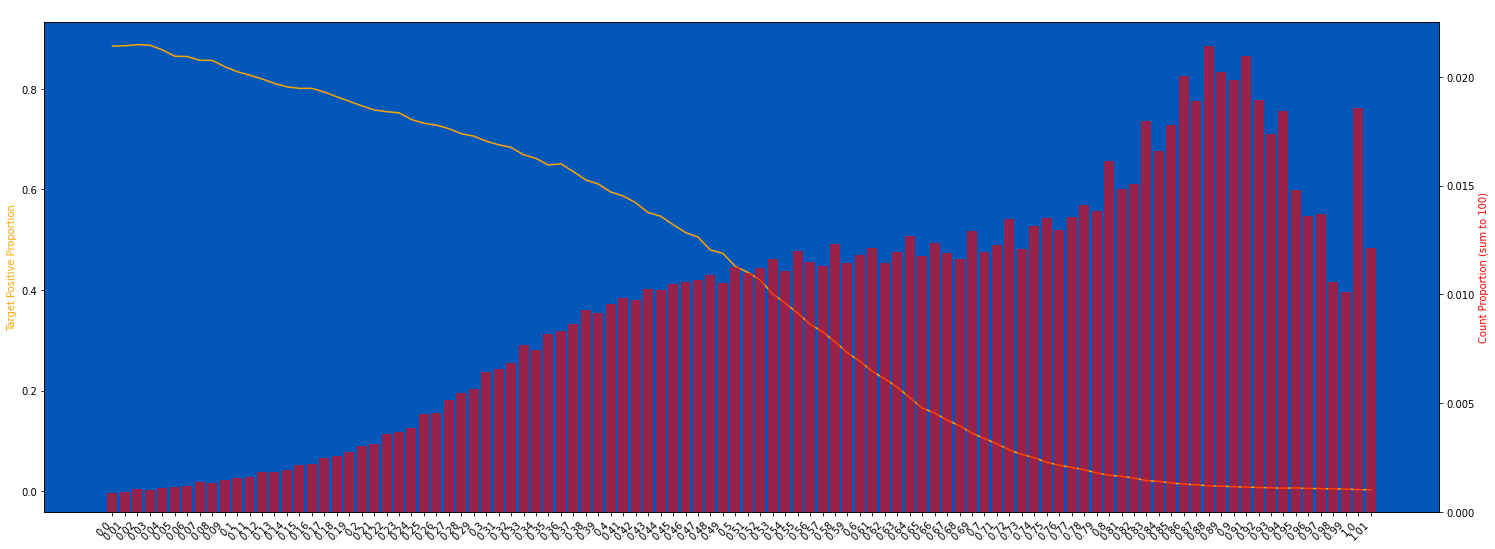

In [13]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


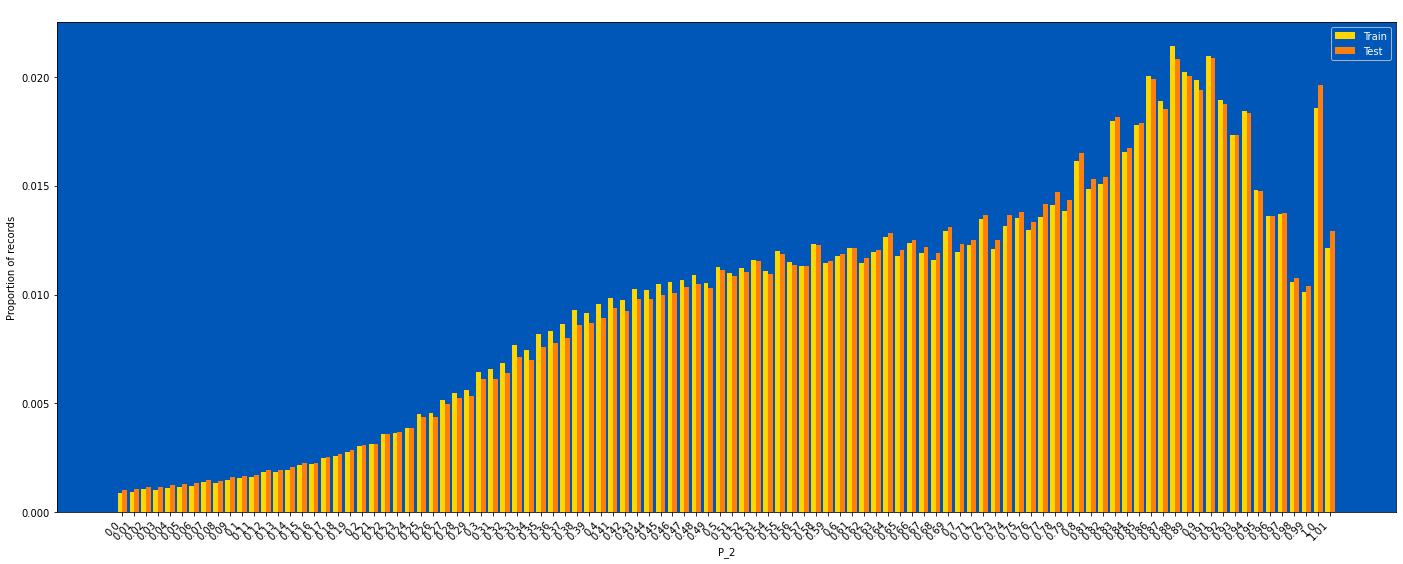

In [14]:
plot_train_test_distribution(train, test, "P_2", nunique_thr=150, figsize=(24, 10))

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


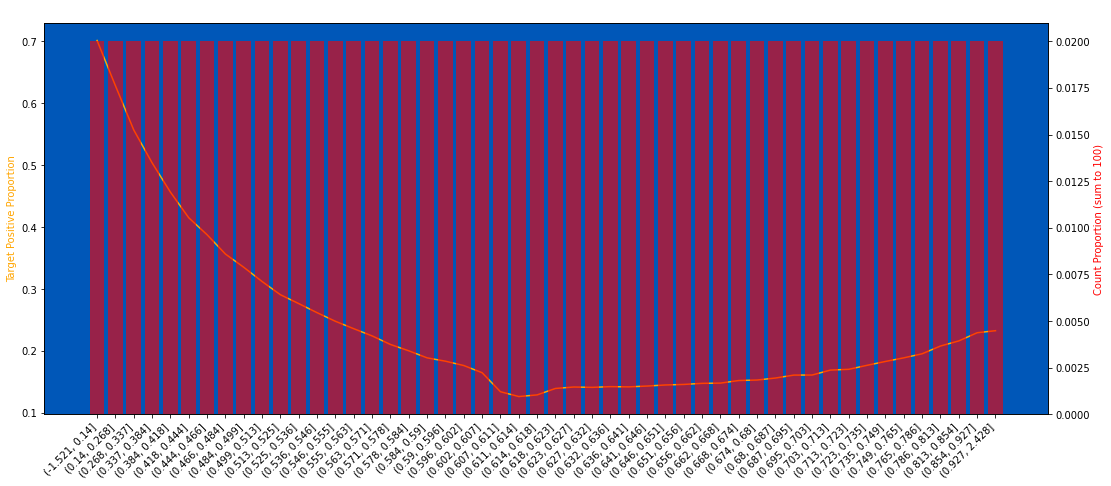

In [15]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [16]:
train["P_3"] = train["P_3"].round(2)
test["P_3"] = test["P_3"].round(2)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


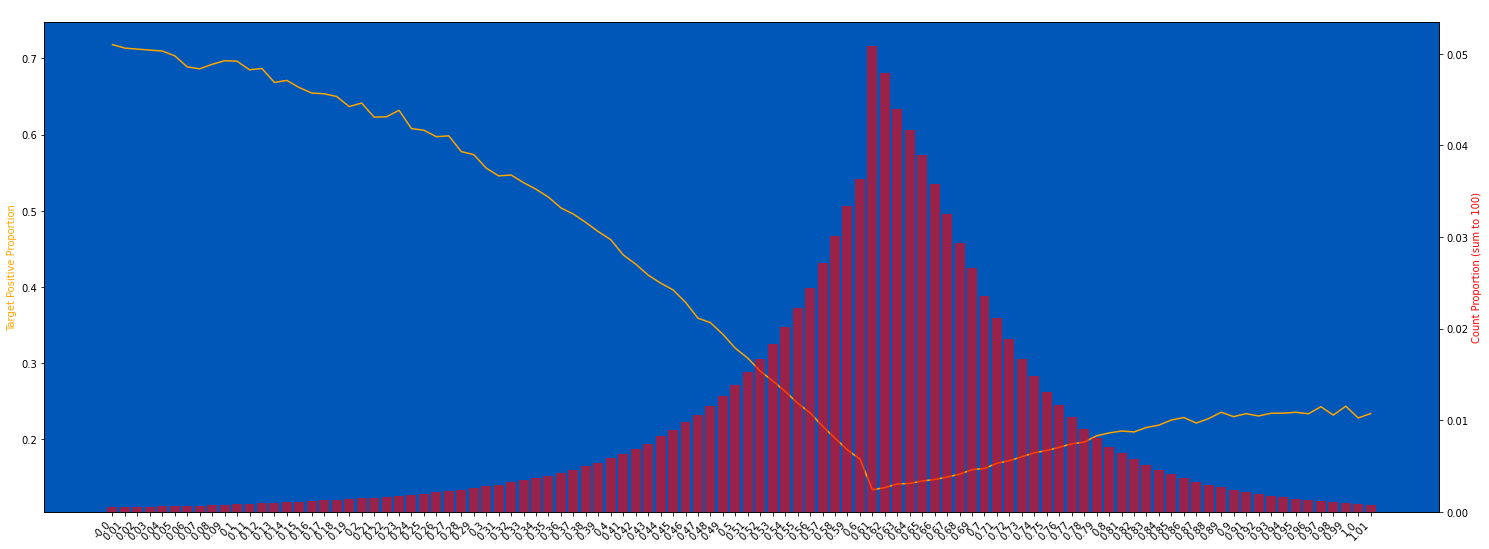

In [17]:
p3_summary = plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10), drop_outlier=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


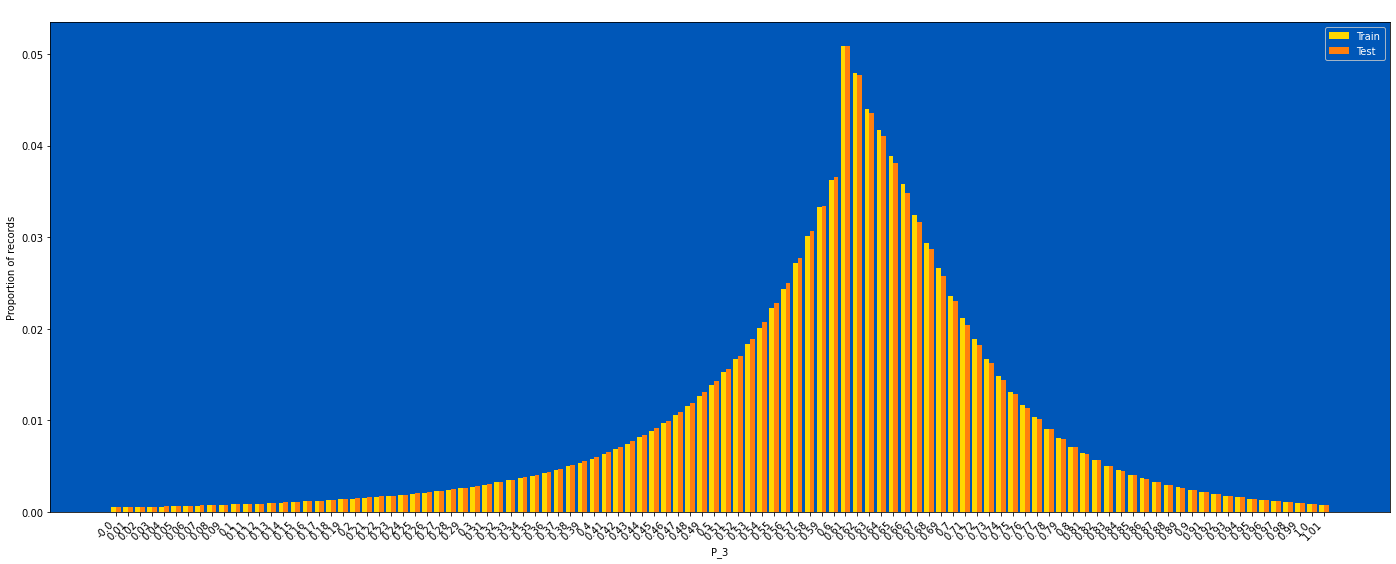

In [19]:
plot_train_test_distribution(train, test, "P_3", nunique_thr=340, figsize=(24, 10))

### P_3a

In [20]:
p3_summary.loc[p3_summary["P_3"].isin([0, 1])]

,P_3,target_mean,count_distribution,proportion_distribution
124,-0.0000,0.7181,2636,0.0005
224,1.0000,0.2282,4627,0.0009


In [21]:
p3_summary.loc[p3_summary["P_3"].between(0.605, 0.615)]

,P_3,target_mean,count_distribution,proportion_distribution
185,0.6100,0.1340,266076,0.0509


In [28]:
left_grad = (0.134 - 0.7181) / (0 - 0.61)
right_grad = (0.2282 - 0.134) / (1 - 0.61)

In [29]:
left_grad, right_grad

(0.9575409836065574, 0.24153846153846148)

In [30]:
train["P_3a"] = (train["P_3"] - 0.61).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10
test["P_3a"] = (test["P_3"] - 0.61).apply(lambda x: right_grad * x if x >= 0 else -left_grad * x) * 10

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


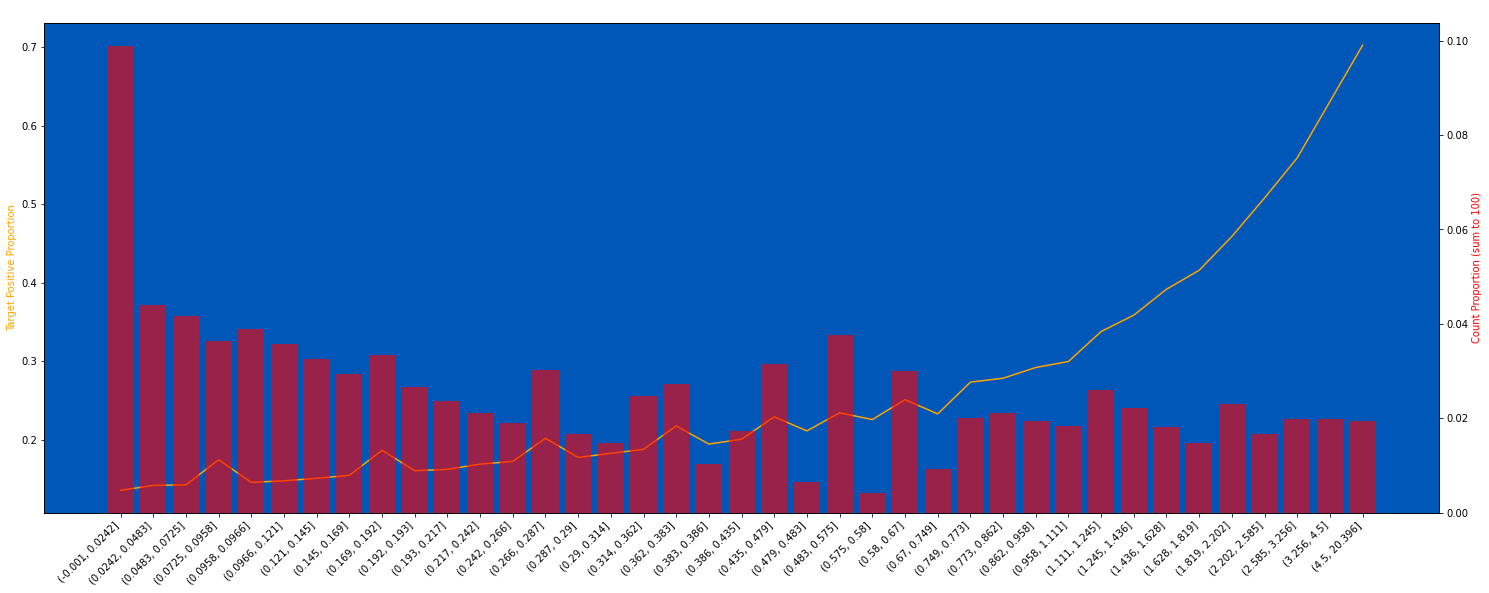

In [31]:
plot_target_check(train, "P_3a", q=50, use_raw_bin=True, nunique_thr=150, figsize=(25, 10))

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


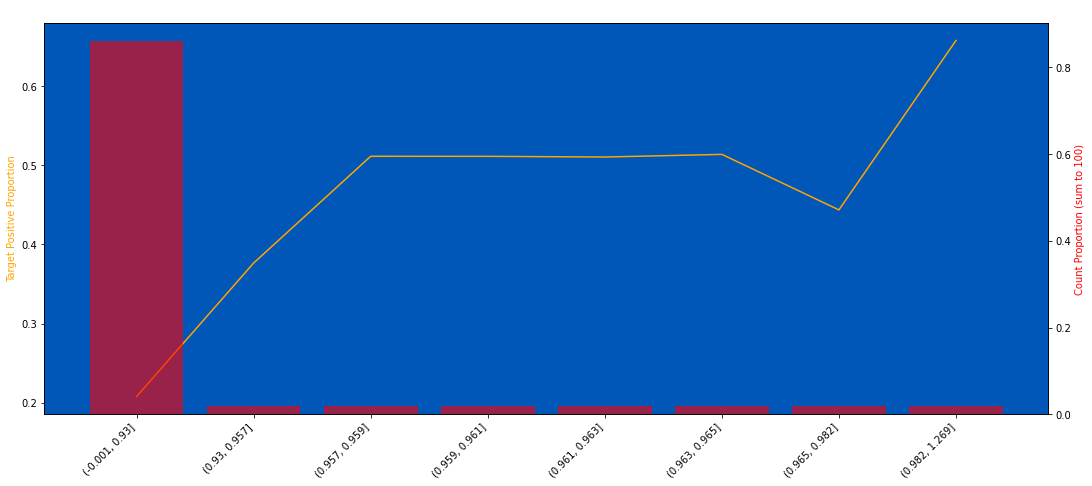

In [32]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [33]:
train["P_4"] = train["P_4"].round(2)
test["P_4"] = test["P_4"].round(2)

Bottom 1% and Top 1% are dropped from this chart


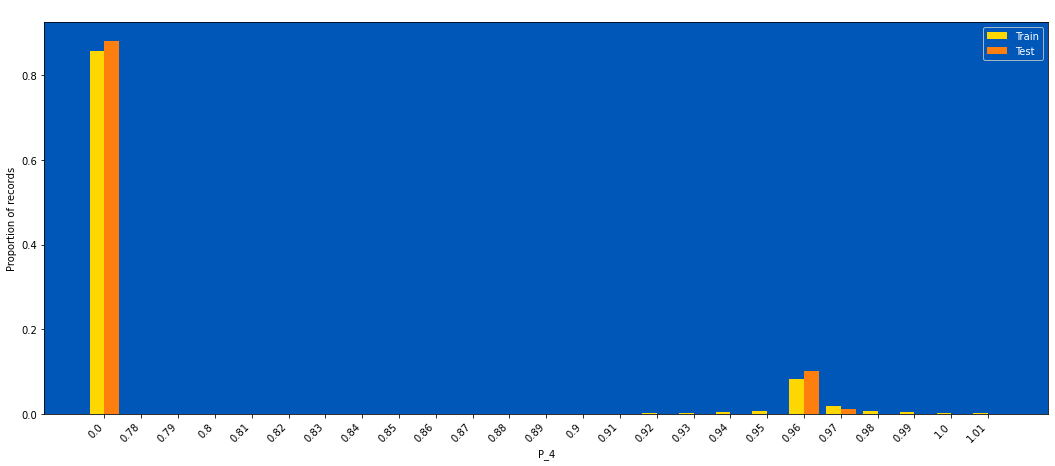

In [34]:
plot_train_test_distribution(train, test, "P_4")

In [35]:
train["P_4"] = train["P_4"].replace(0, np.nan)
test["P_4"] = test["P_4"].replace(0, np.nan)

Bottom 1% and Top 1% are dropped from this chart


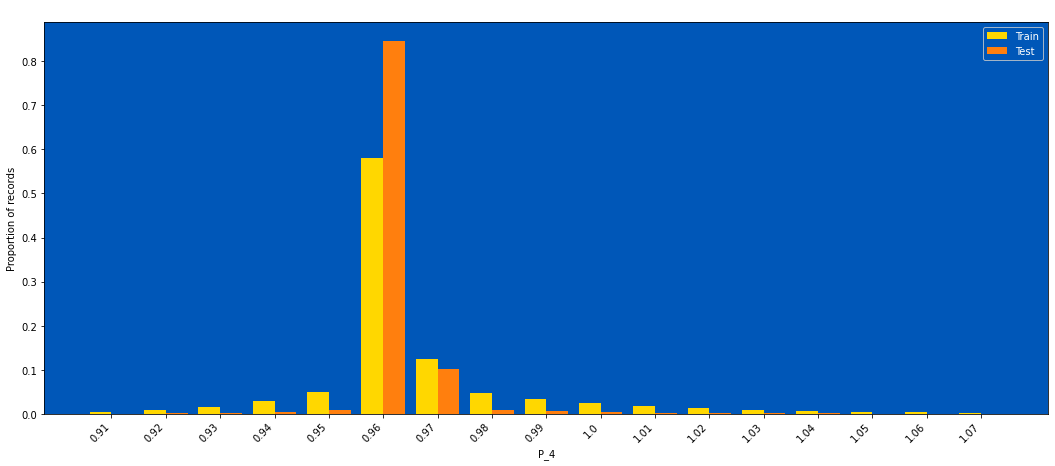

In [36]:
plot_train_test_distribution(train, test, "P_4")

4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


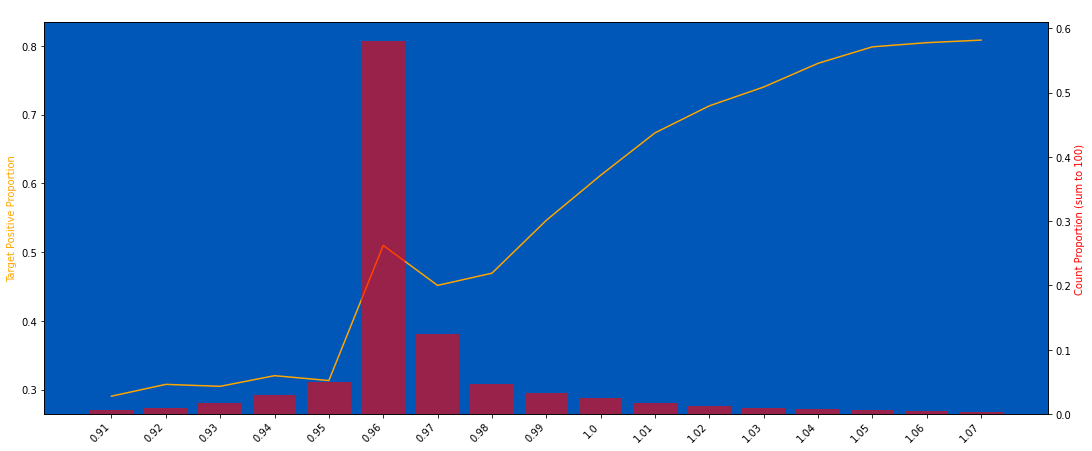

In [37]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


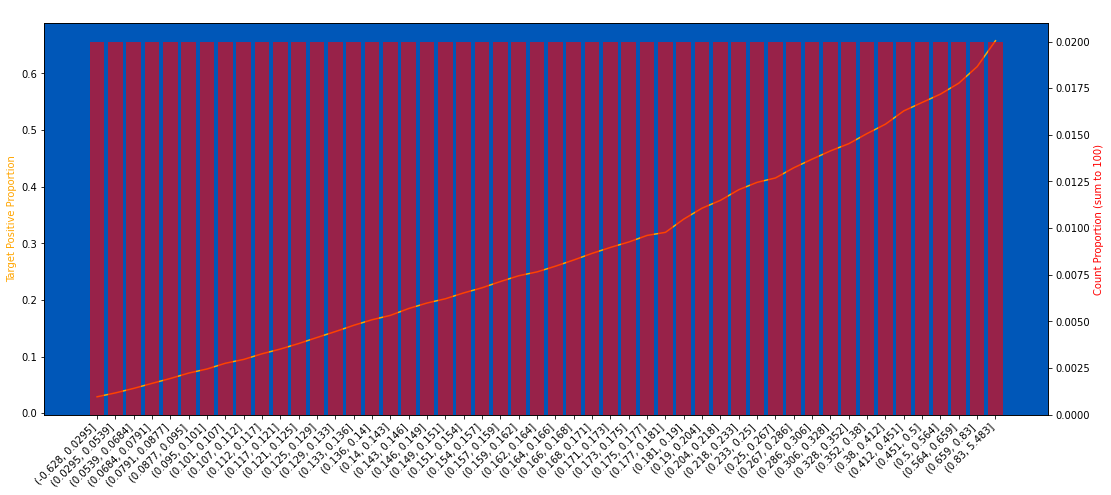

In [38]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [39]:
train["S_3"] = train["S_3"].round(2)
test["S_3"] = test["S_3"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


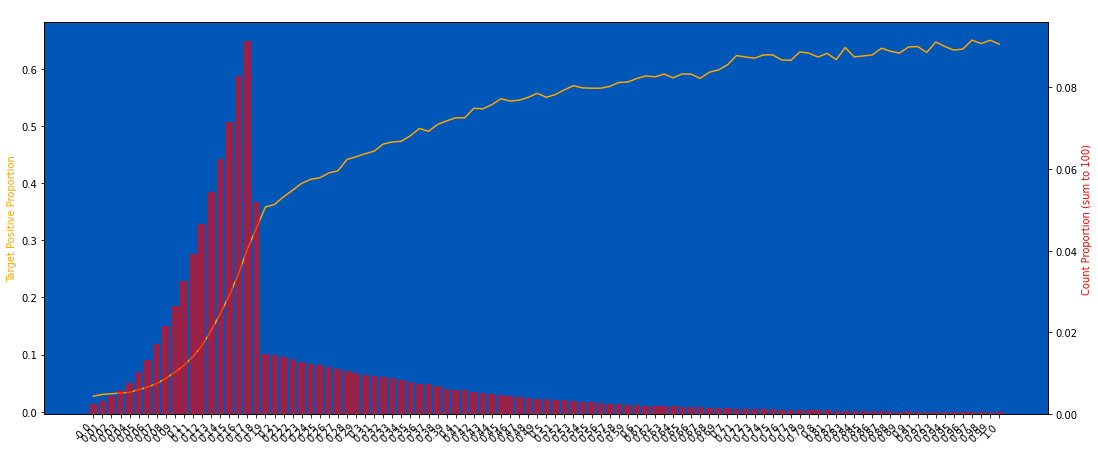

In [40]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=400, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


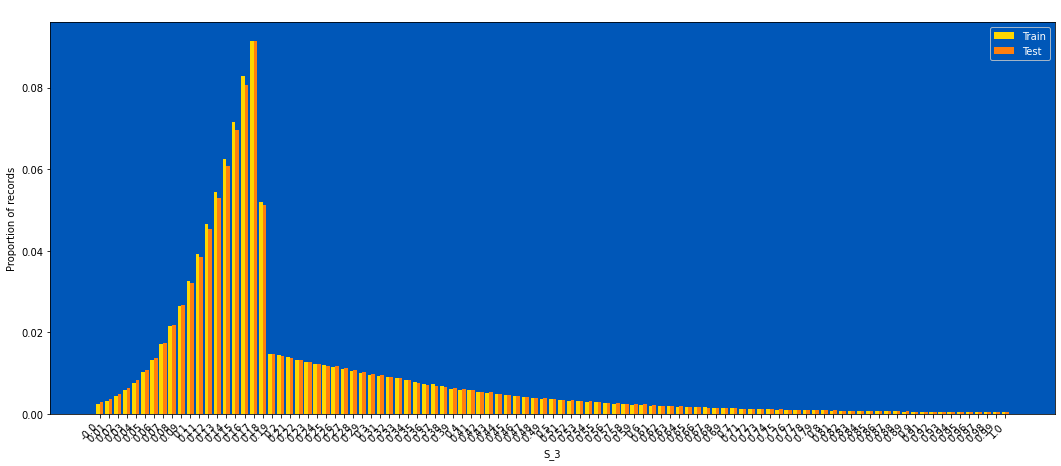

In [41]:
plot_train_test_distribution(train, test, "S_3", nunique_thr=500)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


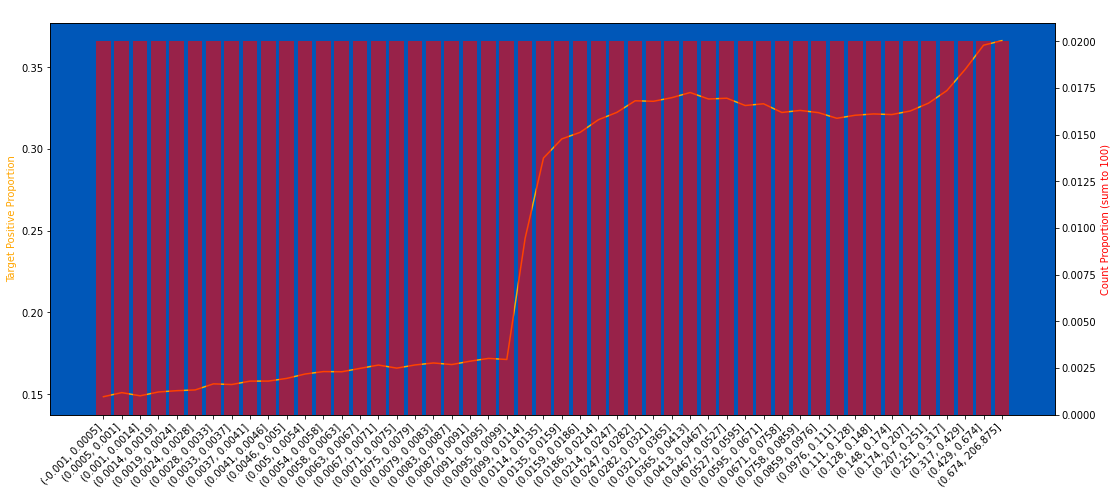

In [42]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [43]:
train["S_5"] = train["S_5"].round(2)
test["S_5"] = test["S_5"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


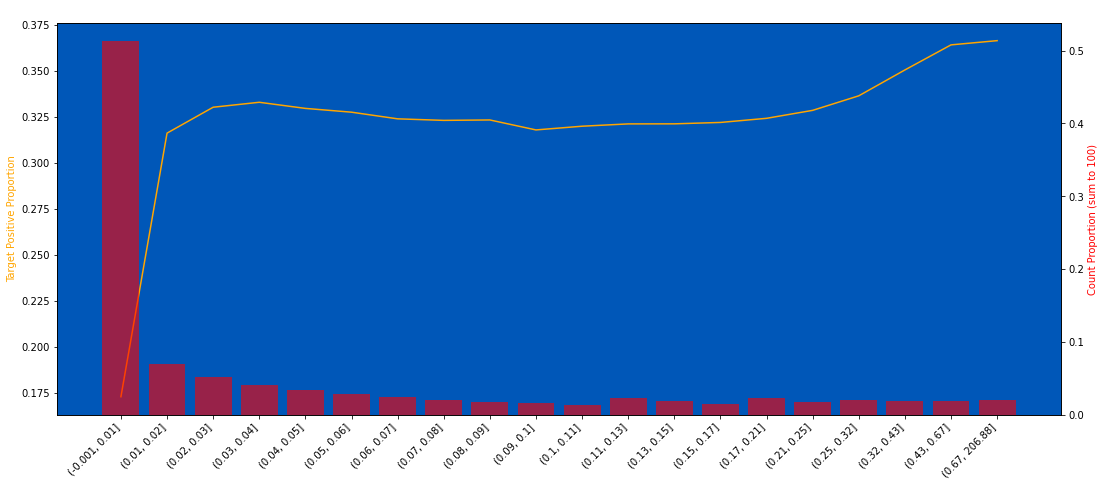

In [44]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [45]:
# plot_train_test_distribution(train, test, "S_5")

### S_6

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


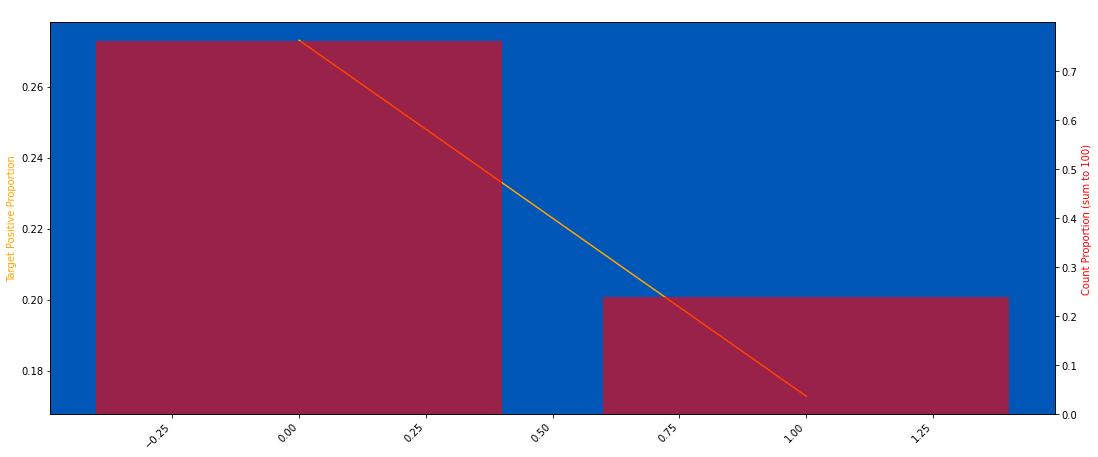

In [46]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


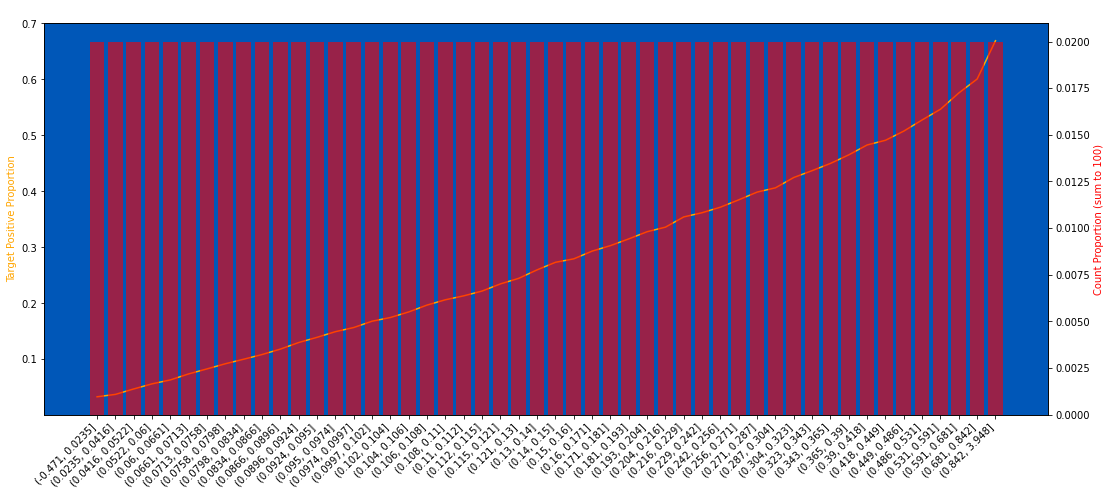

In [47]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [48]:
train["S_7"] = train["S_7"].round(2)
test["S_7"] = test["S_7"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


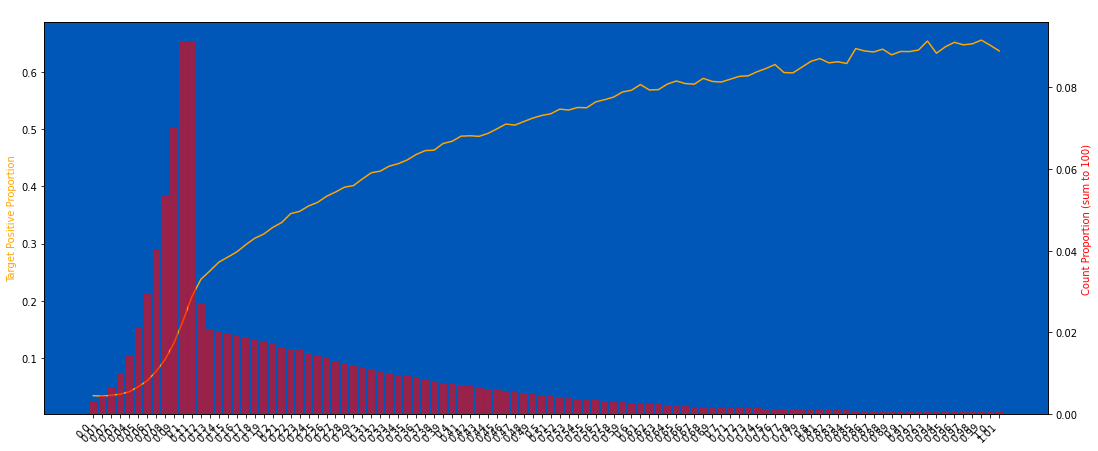

In [53]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


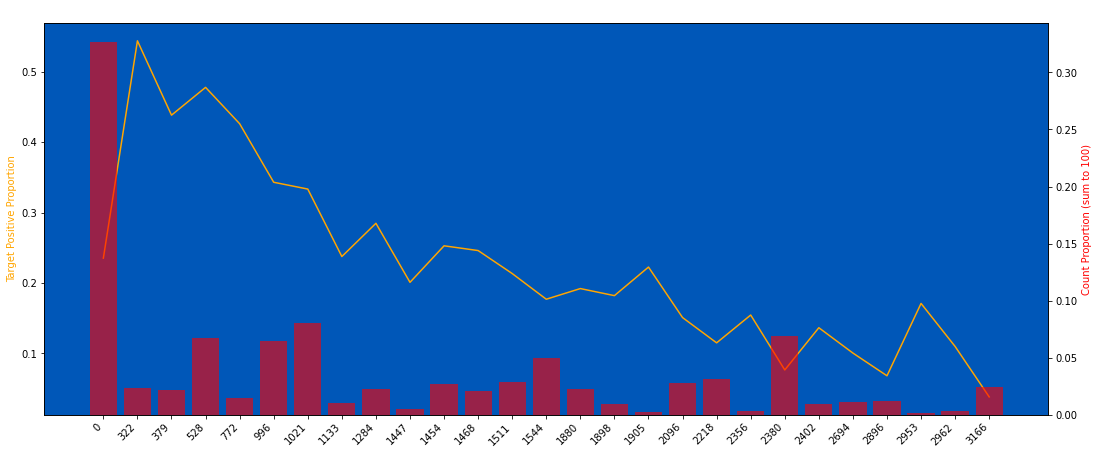

In [54]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


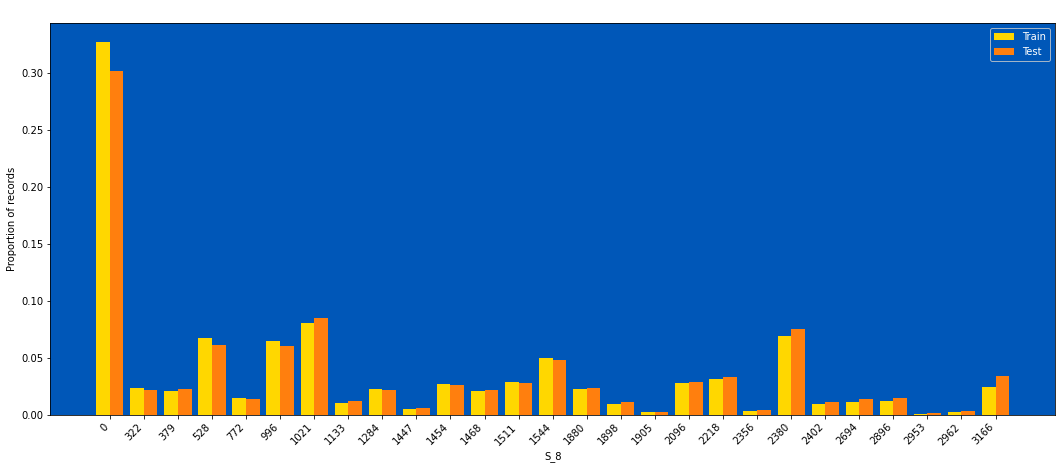

In [55]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500)

In [63]:
s8_mapping_dict = dict(zip(sorted(train["S_8"].unique()), range(train["S_8"].nunique())))

In [65]:
train["S_8"] = train["S_8"].map(s8_mapping_dict).replace(0, np.nan)
test["S_8"] = test["S_8"].map(s8_mapping_dict).replace(0, np.nan)

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


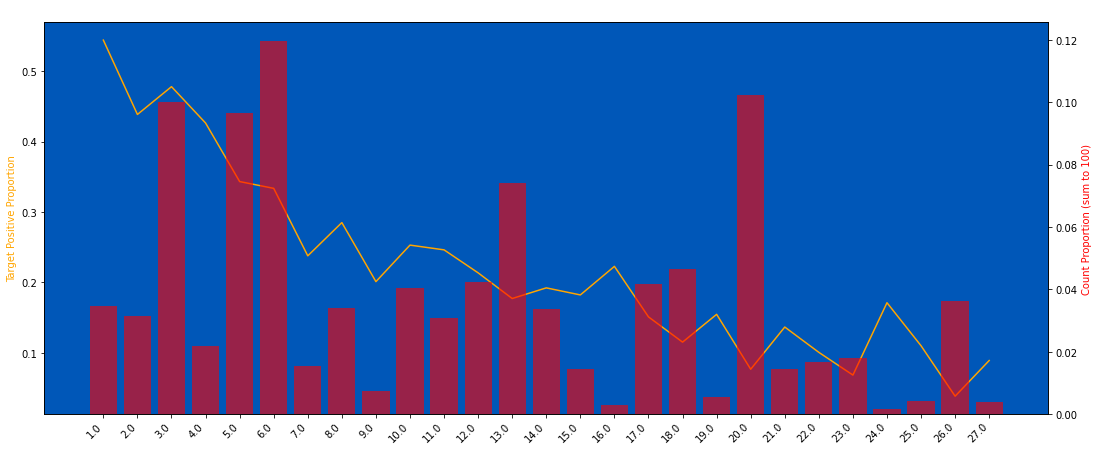

In [66]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


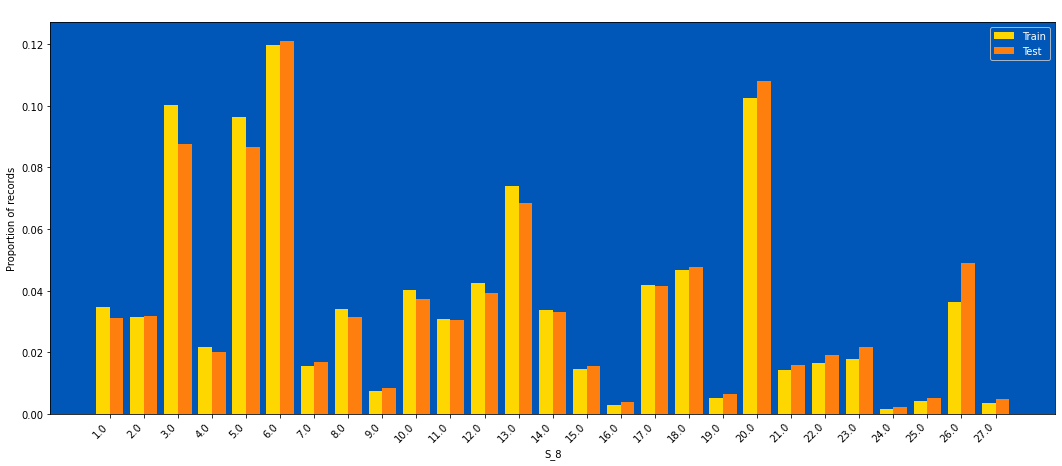

In [67]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


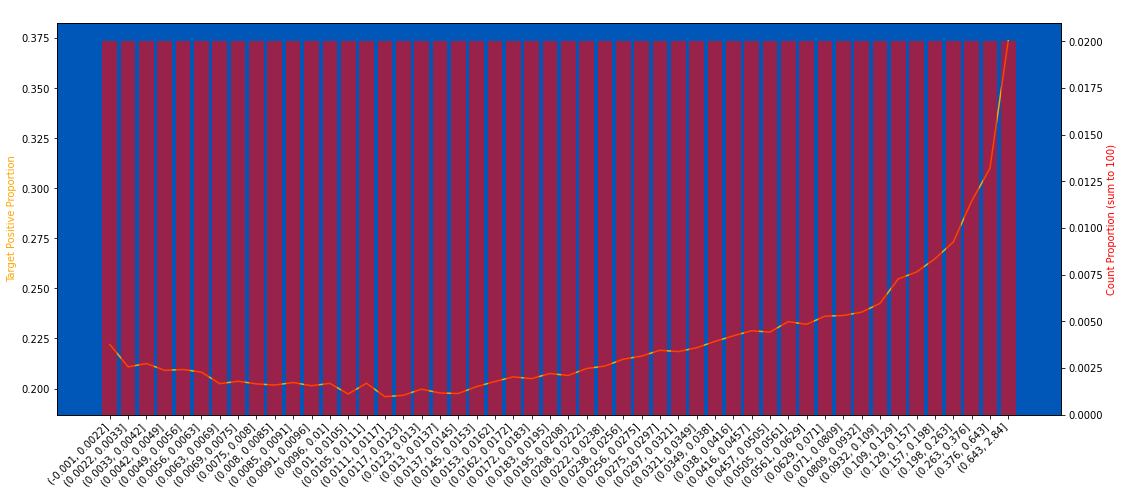

In [68]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [69]:
train["S_9"] = train["S_9"].round(2)
test["S_9"] = test["S_9"].round(2)

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


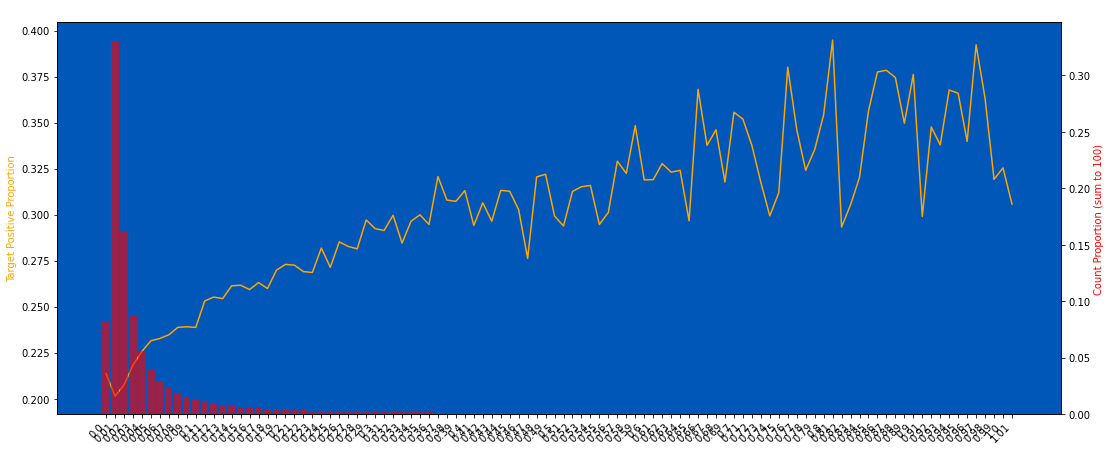

In [72]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


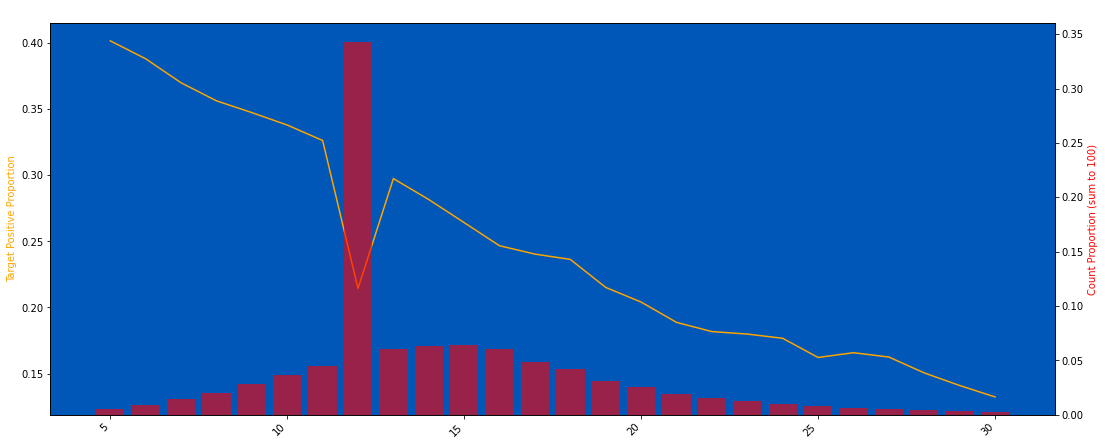

In [73]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


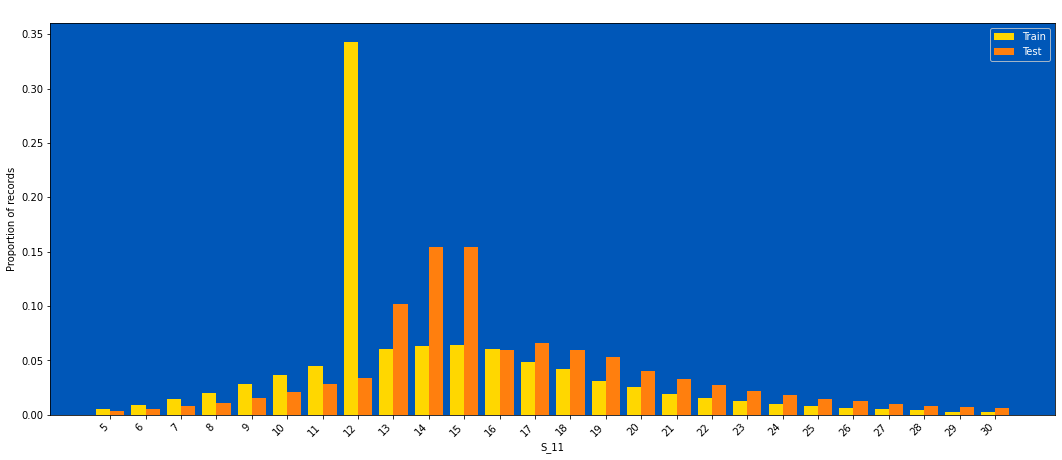

In [75]:
plot_train_test_distribution(train, test, "S_11", nunique_thr=500)

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


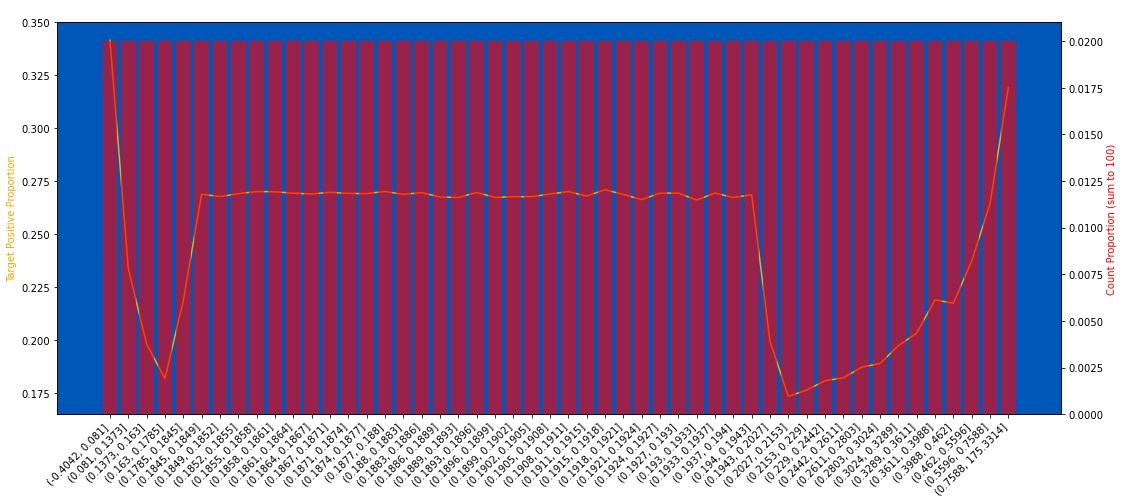

In [32]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [33]:
train["S_12"] = train["S_12"].round(2)
test["S_12"] = test["S_12"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


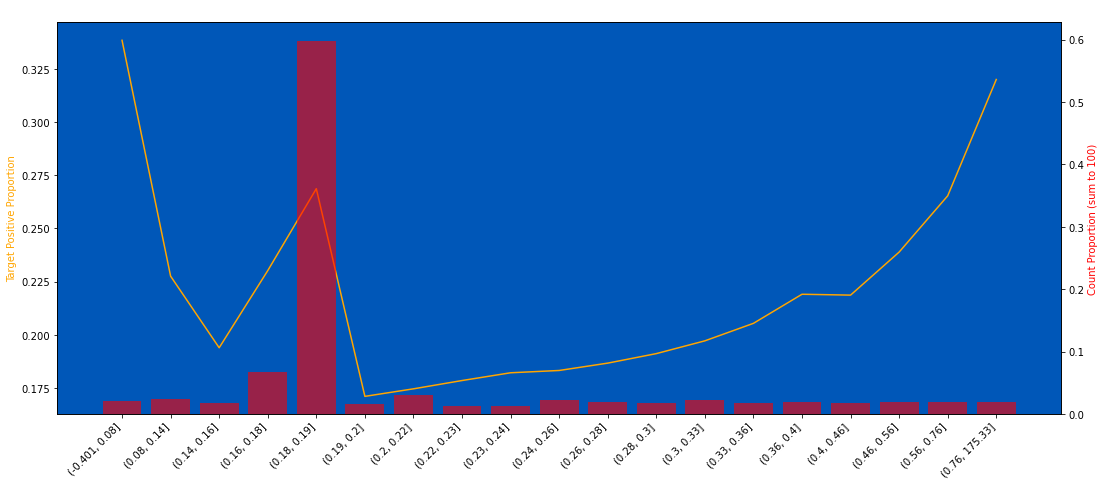

In [34]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1


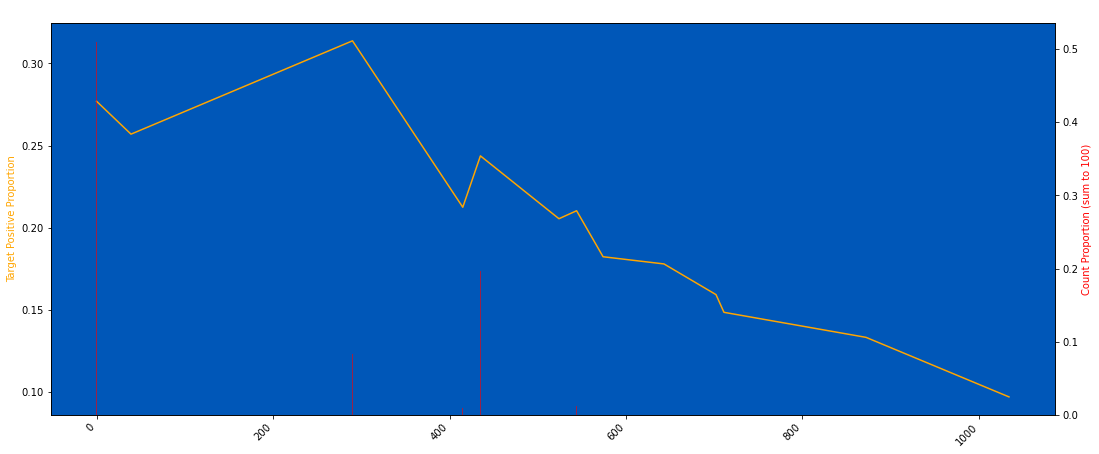

In [35]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1


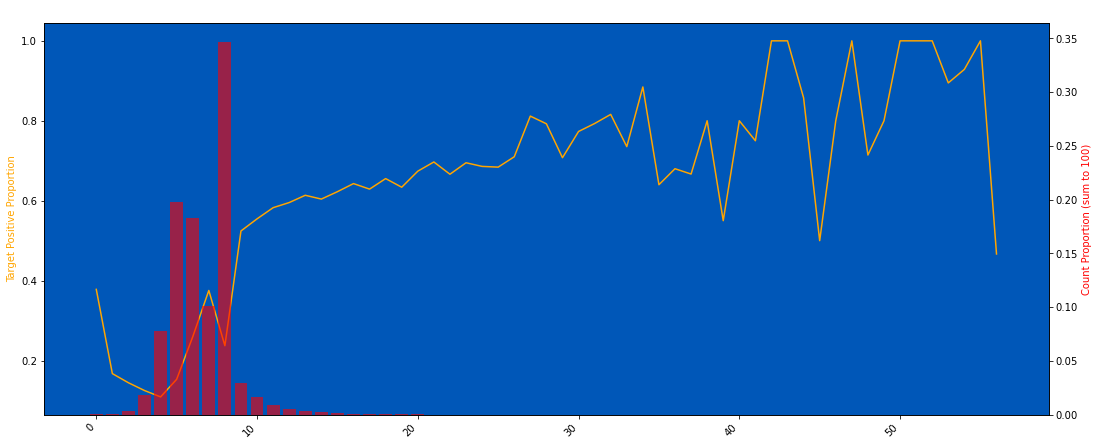

In [36]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


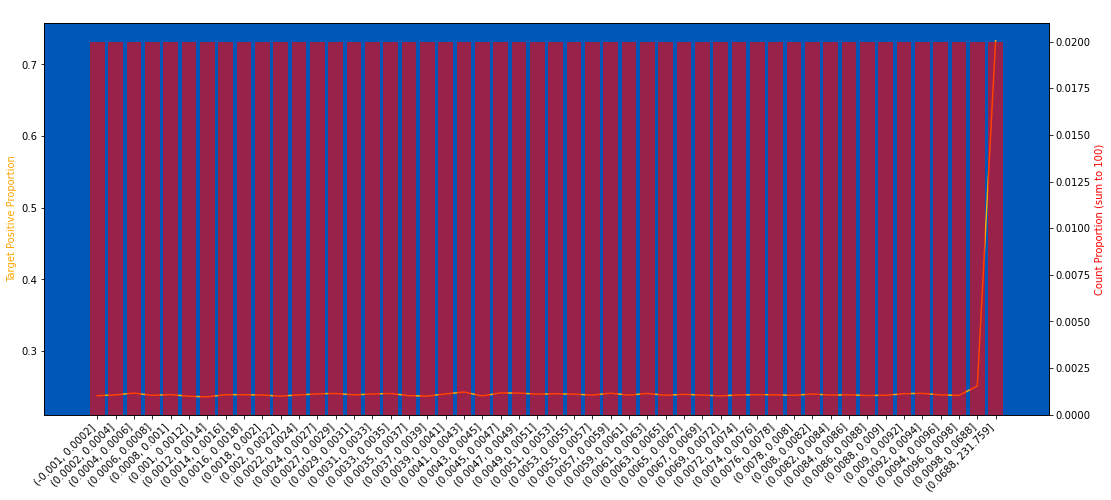

In [37]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [38]:
train["S_16"] = train["S_16"].round(2)
test["S_16"] = test["S_16"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


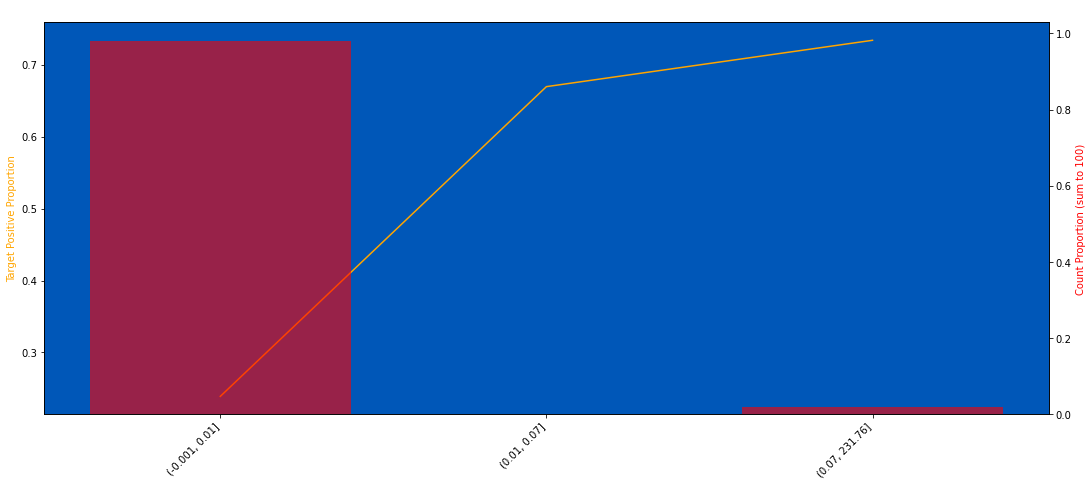

In [39]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


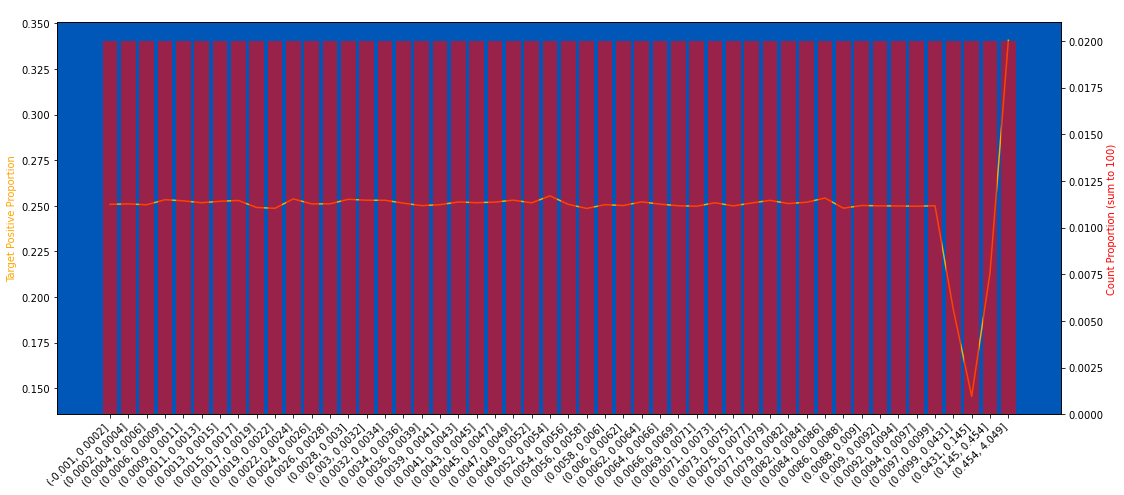

In [40]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [41]:
train["S_17"] = train["S_17"].round(2)
test["S_17"] = test["S_17"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


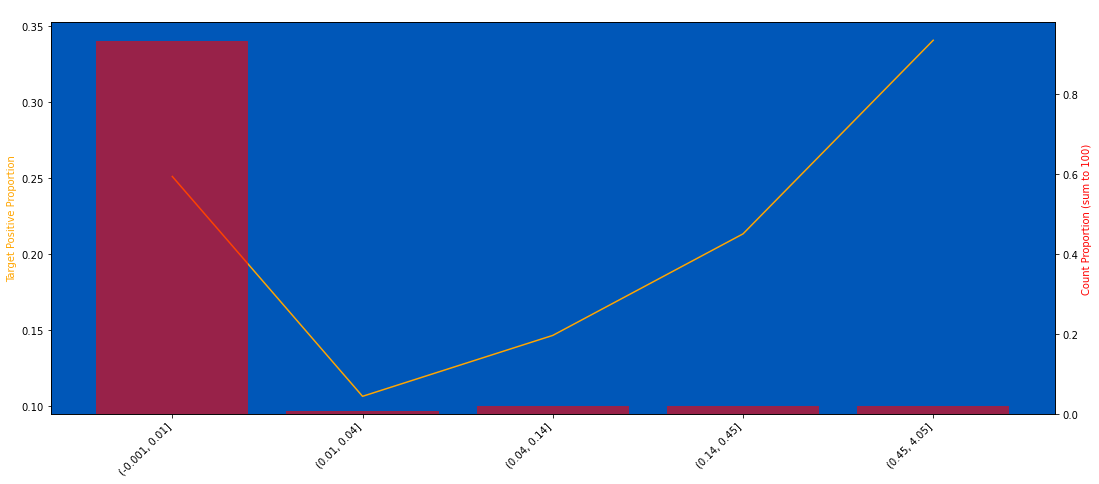

In [42]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


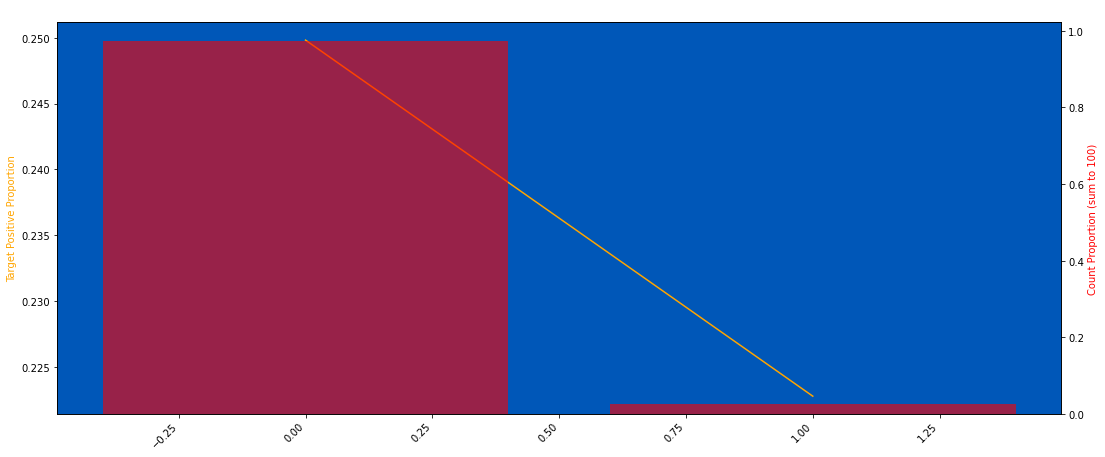

In [43]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


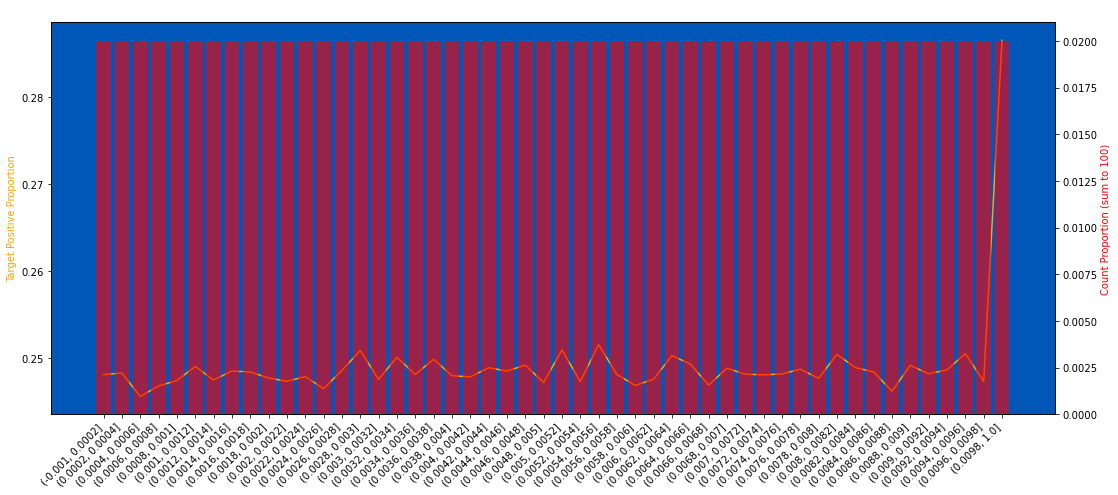

In [44]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [45]:
train["S_19"] = train["S_19"].round(2)
test["S_19"] = test["S_19"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


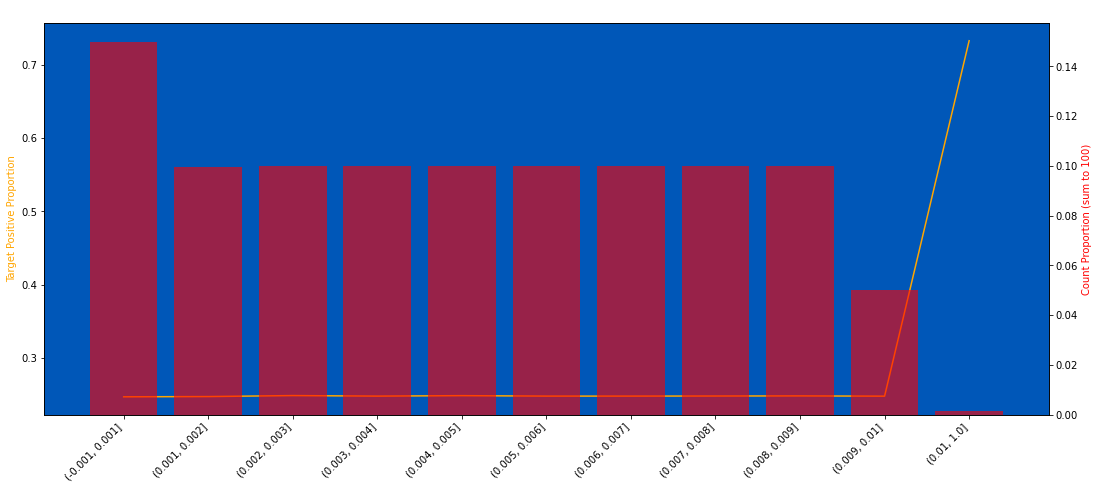

In [46]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1


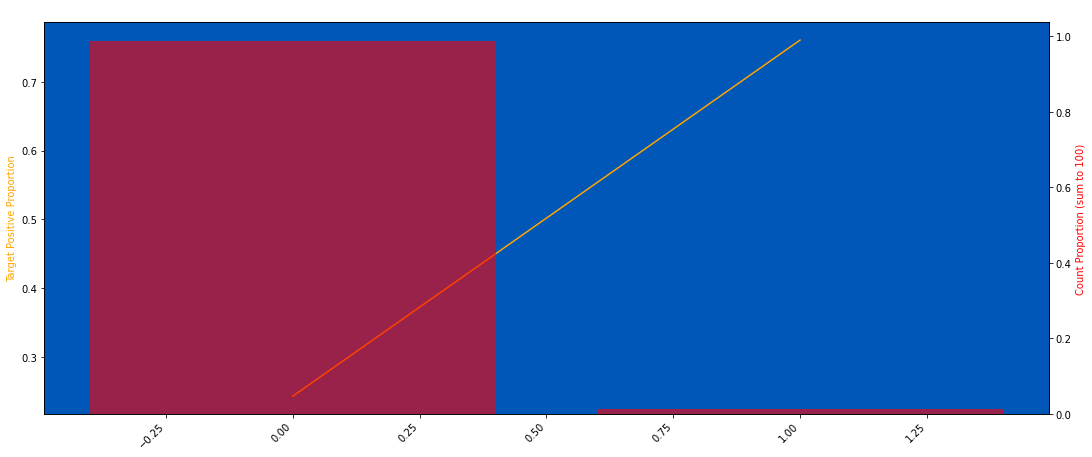

In [47]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


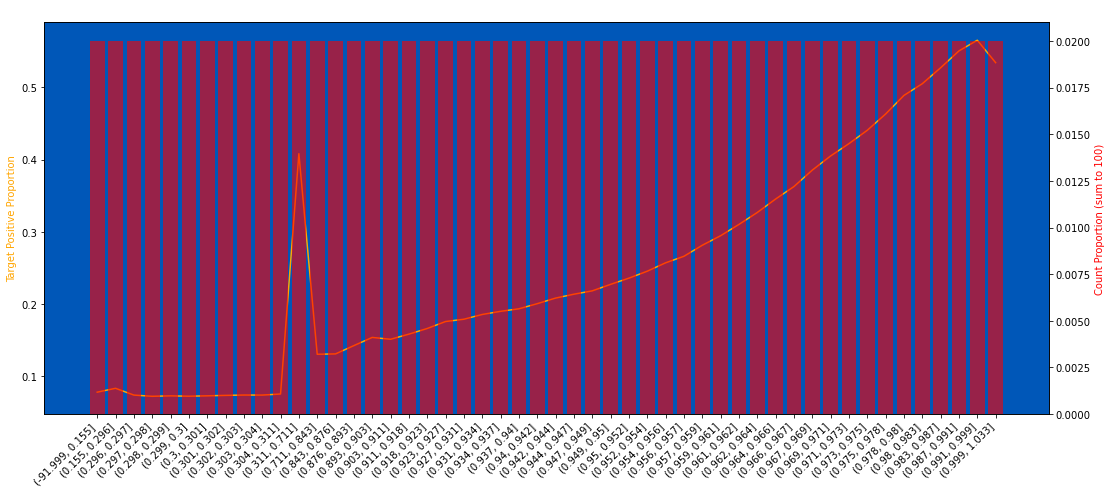

In [48]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


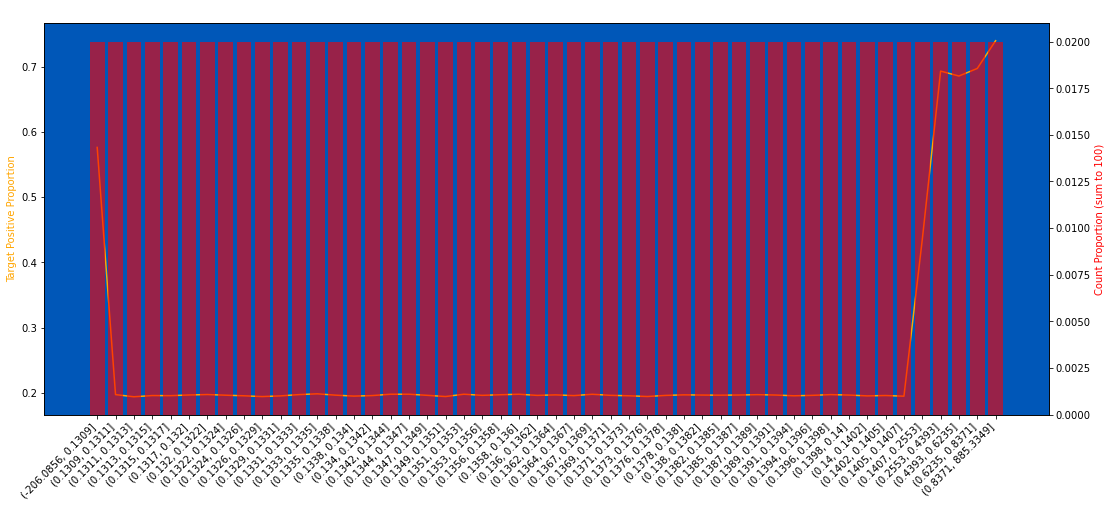

In [49]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [50]:
train["S_23"] = train["S_23"].round(2)
test["S_23"] = test["S_23"].round(2)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


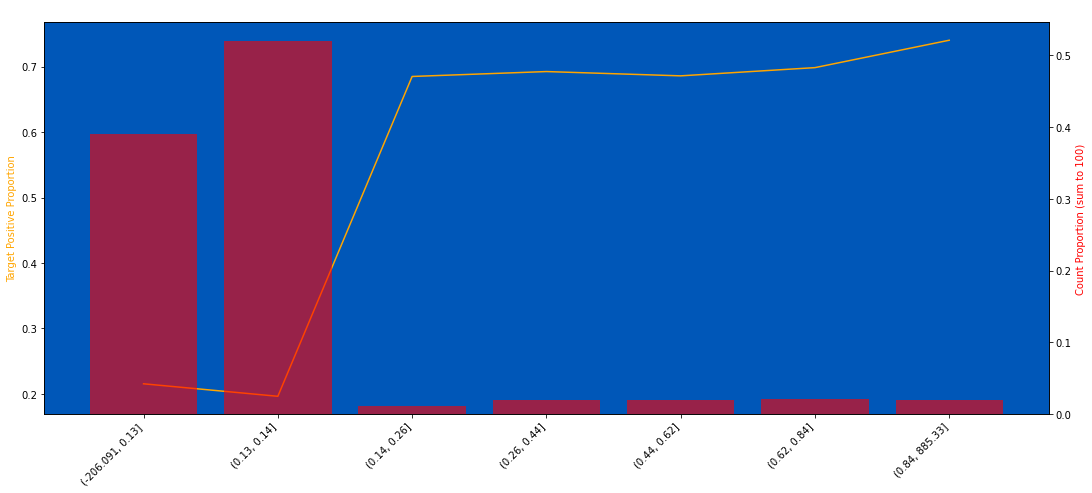

In [51]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


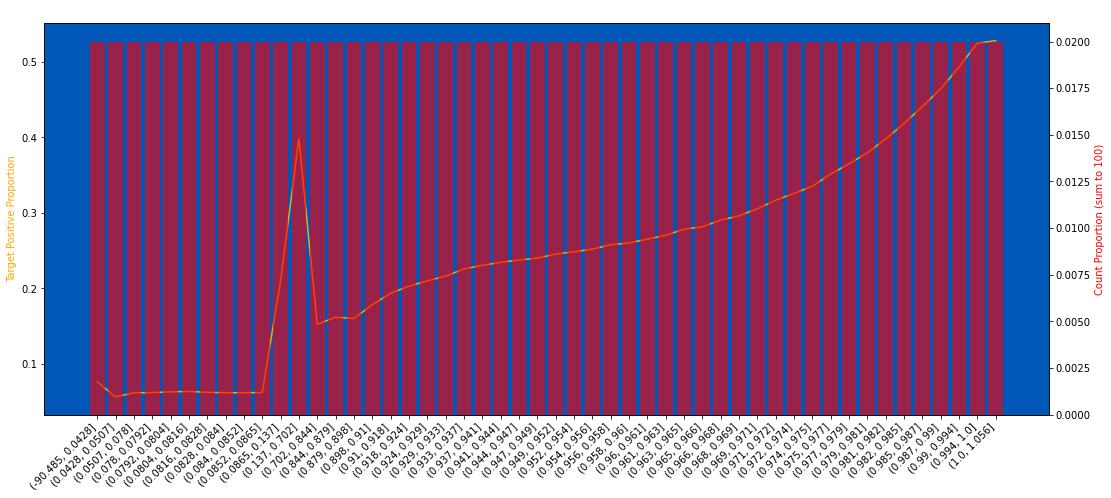

In [52]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [53]:
train["S_24"] = train["S_24"].round(2)
test["S_24"] = test["S_24"].round(2)

In [54]:
train.loc[train["S_24"].between(1, 1.1), "S_24"] = 1
test.loc[test["S_24"].between(1, 1.1), "S_24"] = 1

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


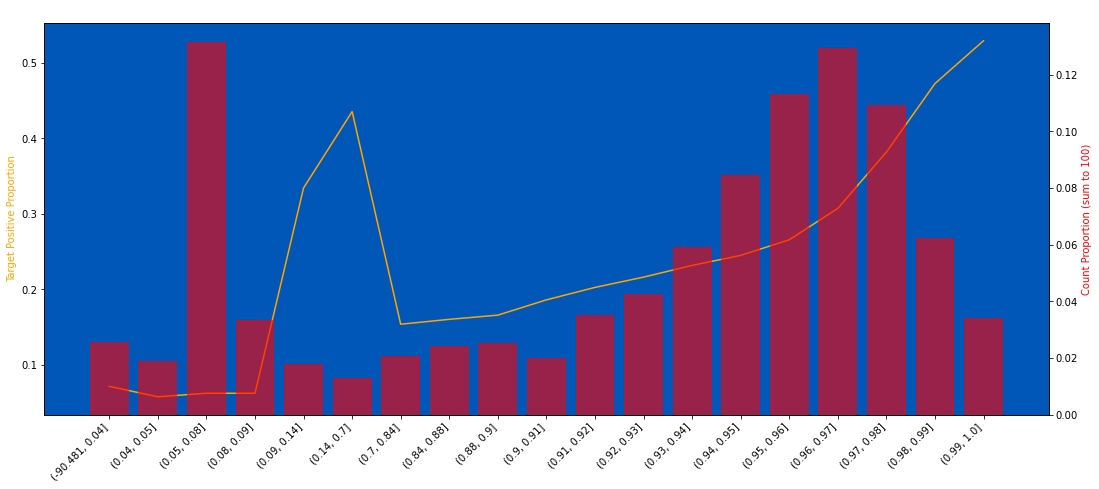

In [55]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


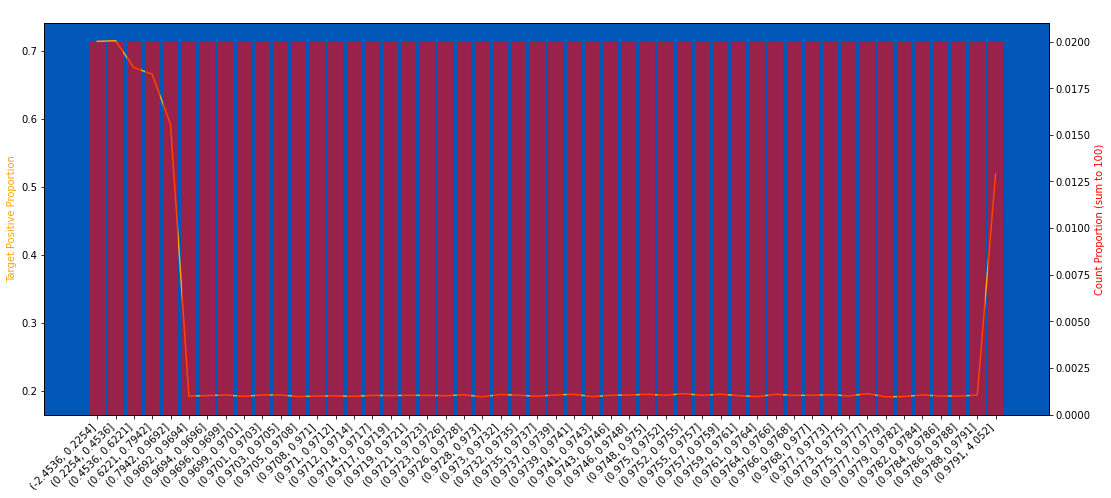

In [56]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [57]:
train["S_25"] = train["S_25"].round(2)
test["S_25"] = test["S_25"].round(2)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


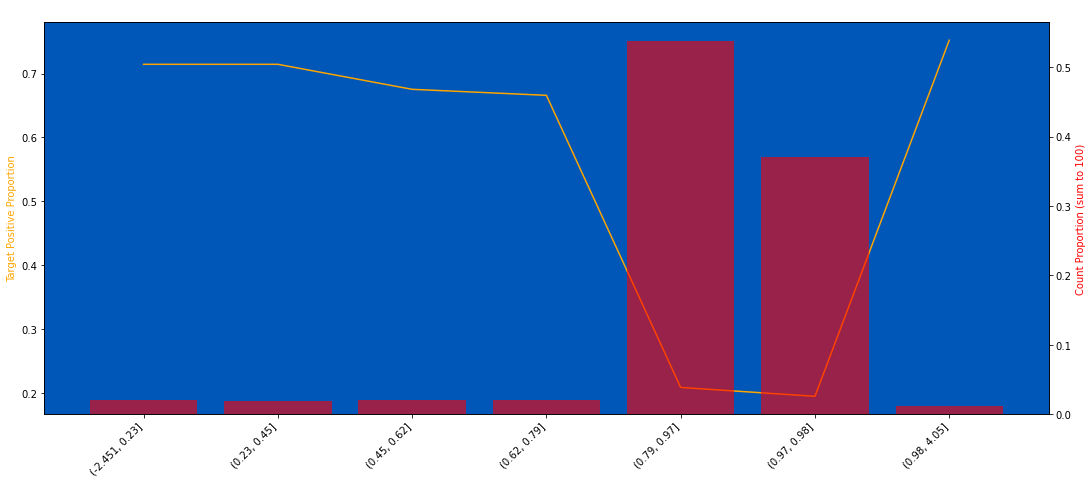

In [58]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


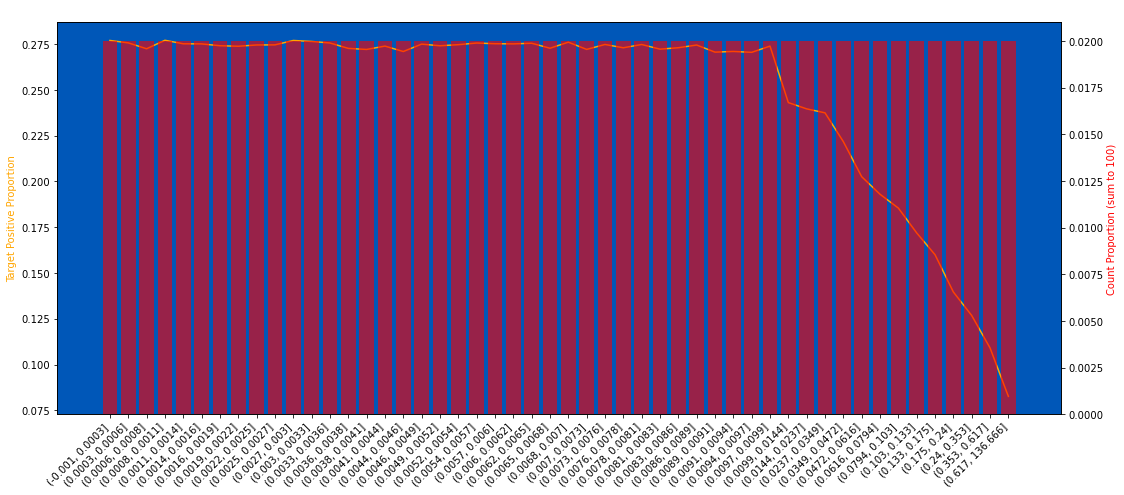

In [59]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [60]:
train["S_26"] = train["S_26"].round(2)
test["S_26"] = test["S_26"].round(2)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


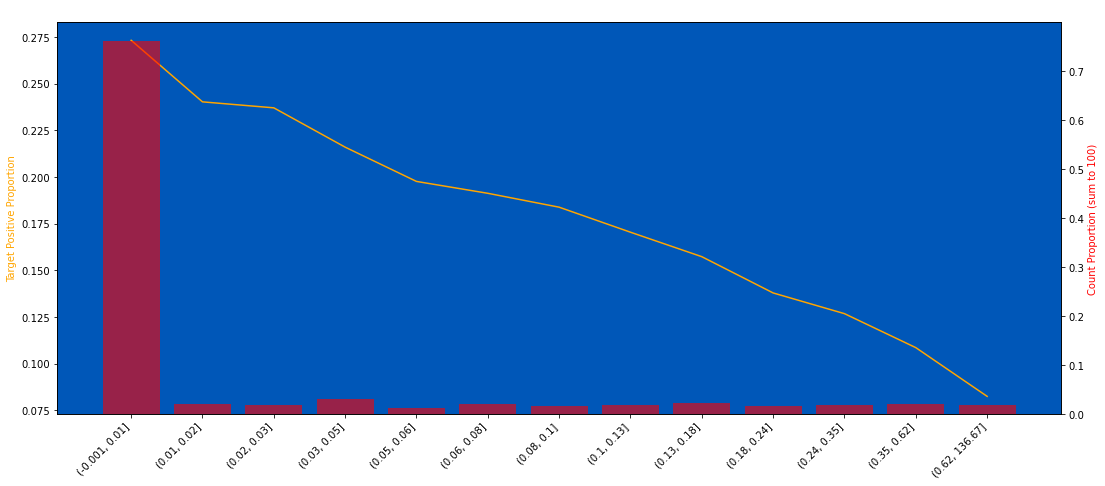

In [61]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


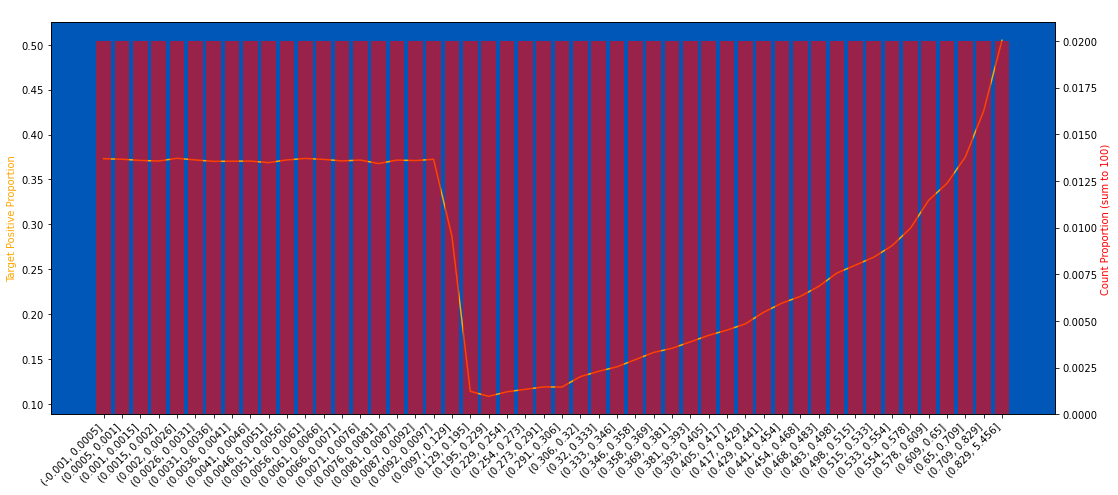

In [63]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [64]:
train["S_27"] = train["S_27"].round(2)
test["S_27"] = test["S_27"].round(2)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


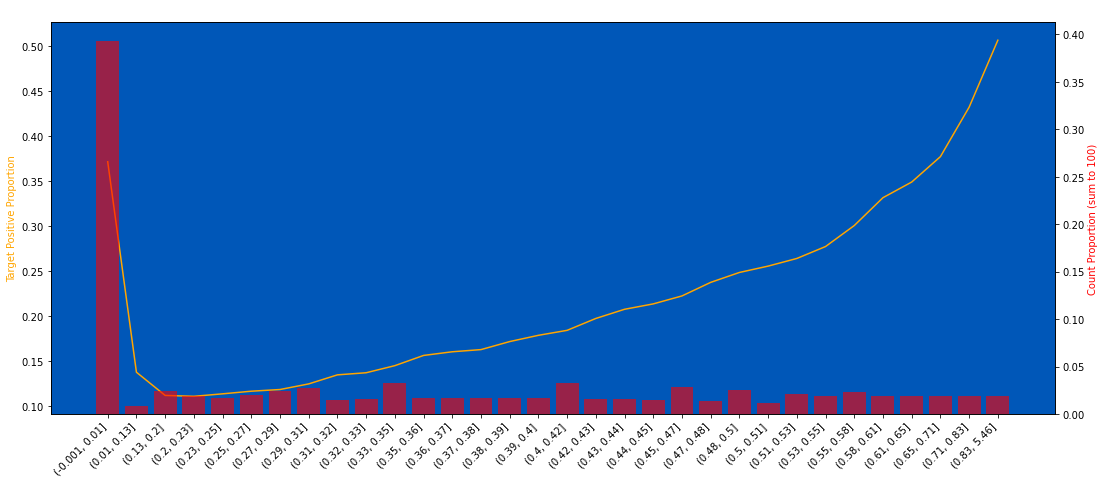

In [65]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

### R_1

0 null count, 0.000 null proportion
nan of the targets have label = 1


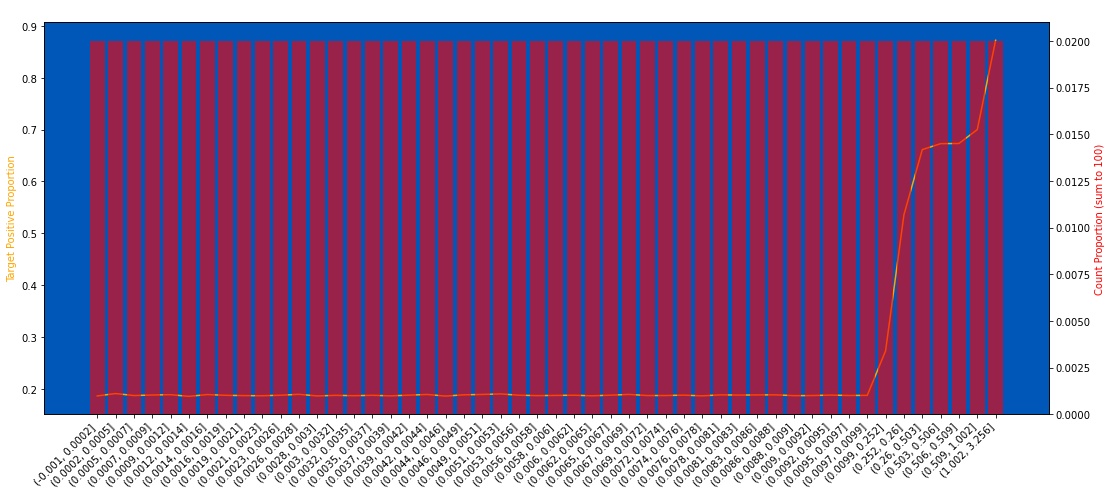

In [11]:
plot_target_check(train, "R_1", q=50, use_raw_bin=True)

In [12]:
train["R_1"] = train["R_1"].round(2)
test["R_1"] = test["R_1"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


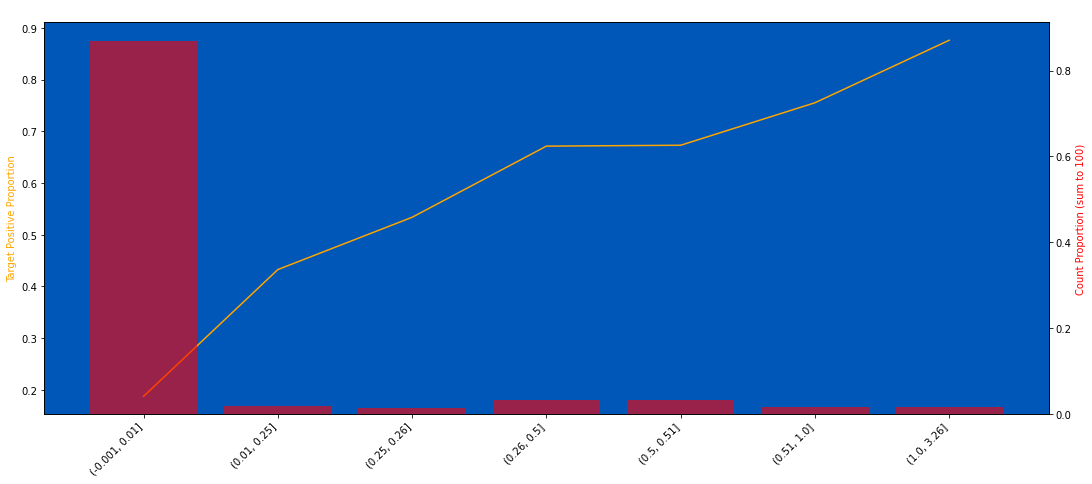

In [13]:
plot_target_check(train, "R_1", q=50, use_raw_bin=True)

### R_2

0 null count, 0.000 null proportion
nan of the targets have label = 1


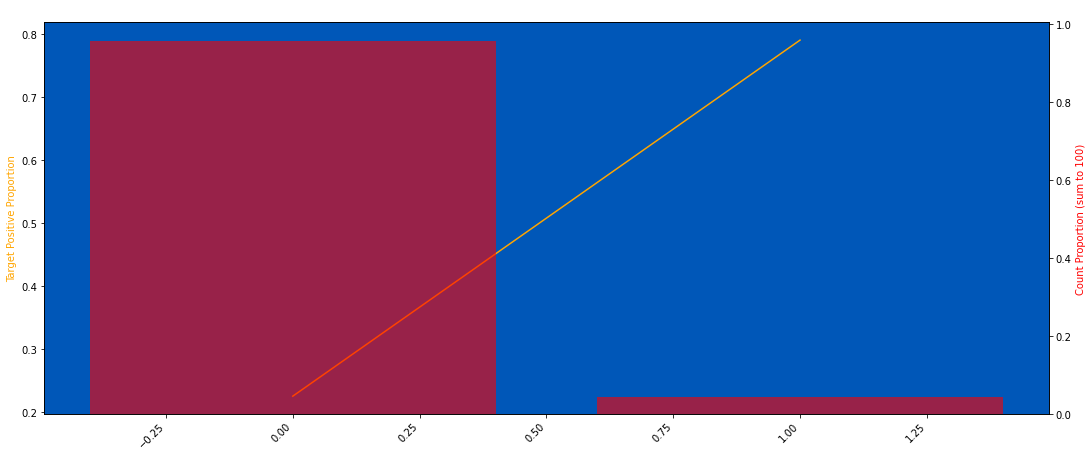

In [14]:
plot_target_check(train, "R_2", q=50, use_raw_bin=True)

### R_3

0 null count, 0.000 null proportion
nan of the targets have label = 1


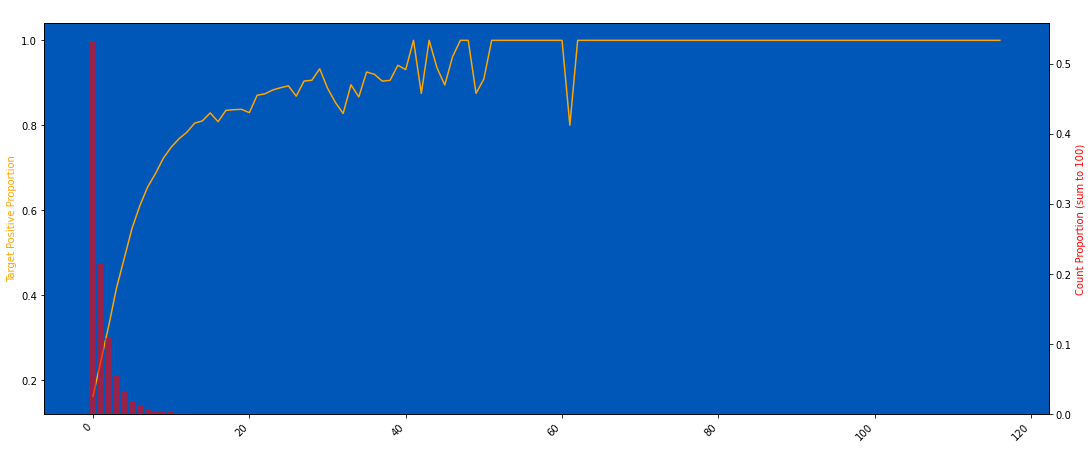

In [15]:
plot_target_check(train, "R_3", q=50, use_raw_bin=True)

### R_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


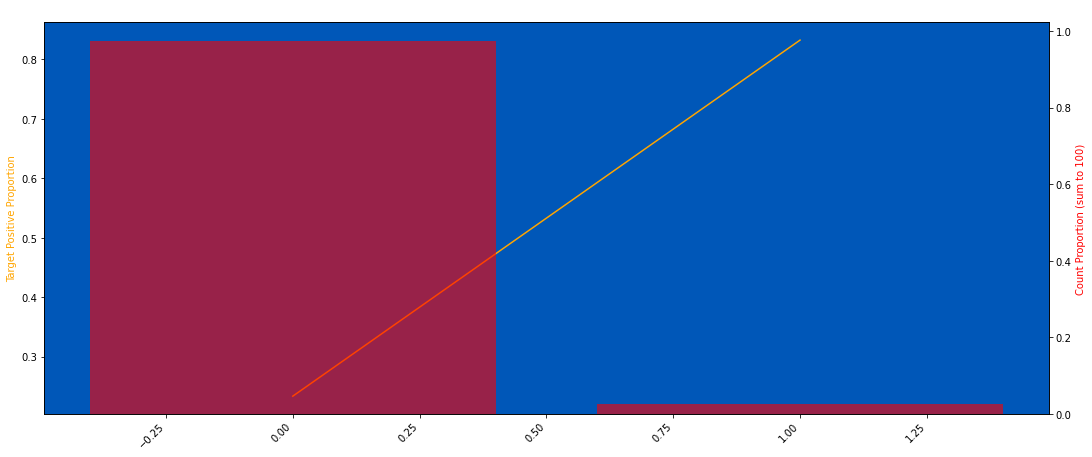

In [16]:
plot_target_check(train, "R_4", q=50, use_raw_bin=True)

### R_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


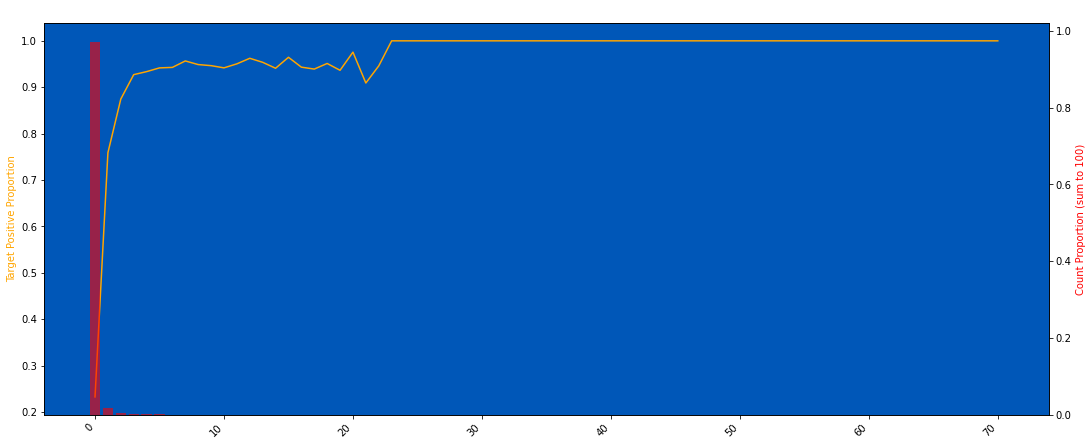

In [17]:
plot_target_check(train, "R_5", q=50, use_raw_bin=True)

### R_6

0 null count, 0.000 null proportion
nan of the targets have label = 1


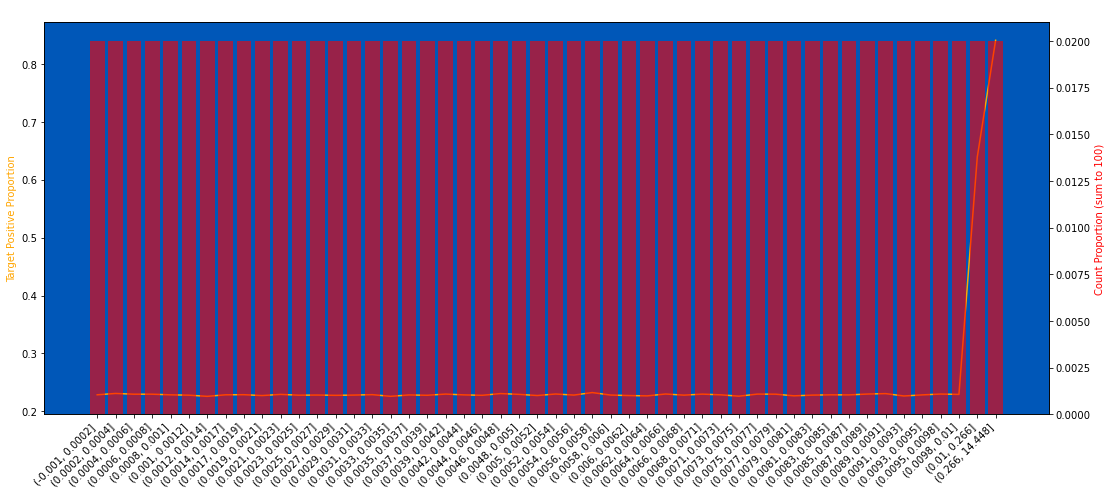

In [18]:
plot_target_check(train, "R_6", q=50, use_raw_bin=True)

In [19]:
train["R_6"] = train["R_6"].round(2)
test["R_6"] = test["R_6"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


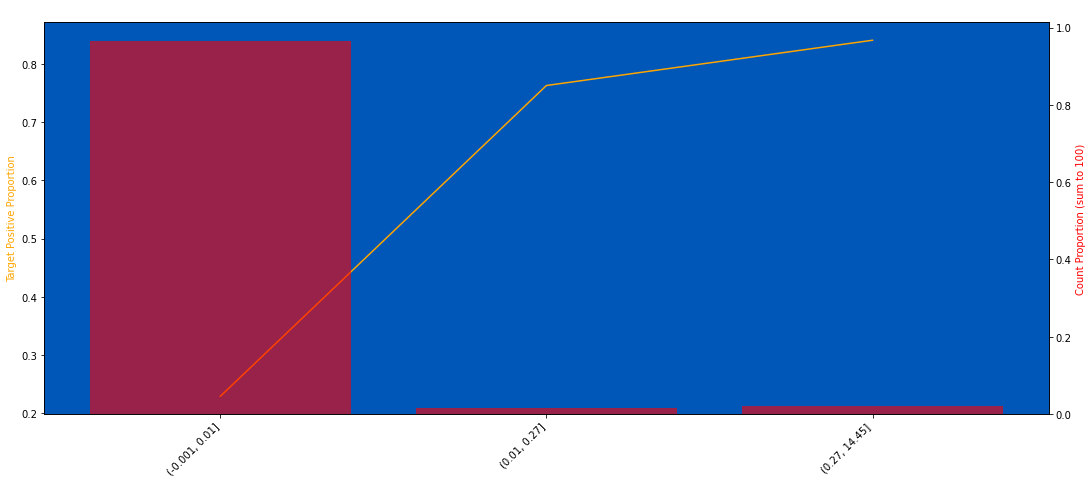

In [20]:
plot_target_check(train, "R_6", q=50, use_raw_bin=True)

### R_7

1 null count, 0.000 null proportion
1.0000 of the targets have label = 1


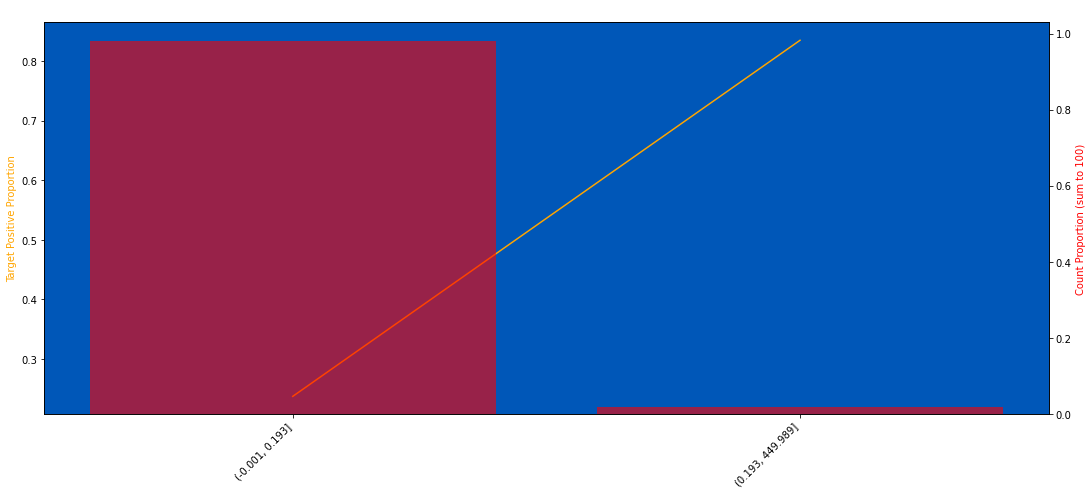

In [21]:
plot_target_check(train, "R_7", q=50, use_raw_bin=True)

### R_8

0 null count, 0.000 null proportion
nan of the targets have label = 1


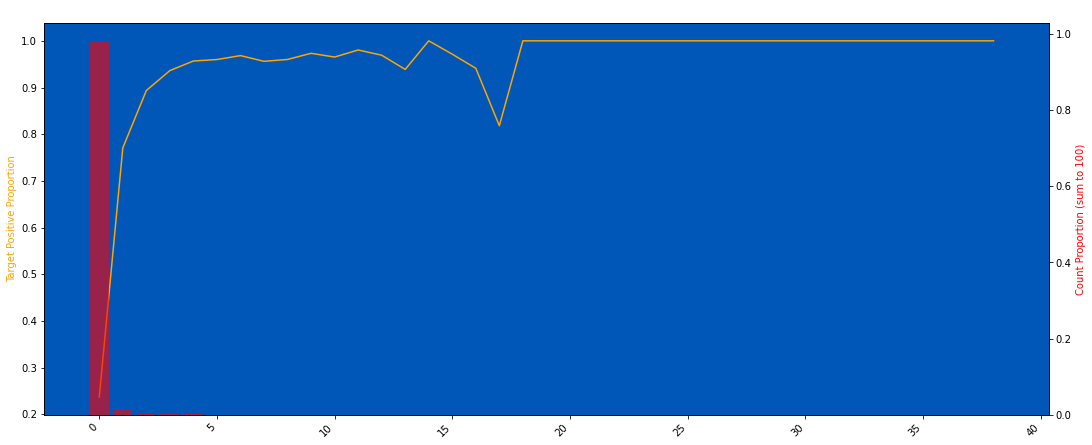

In [22]:
plot_target_check(train, "R_8", q=50, use_raw_bin=True)

### R_9

5218918 null count, 0.943 null proportion
0.2293 of the targets have label = 1


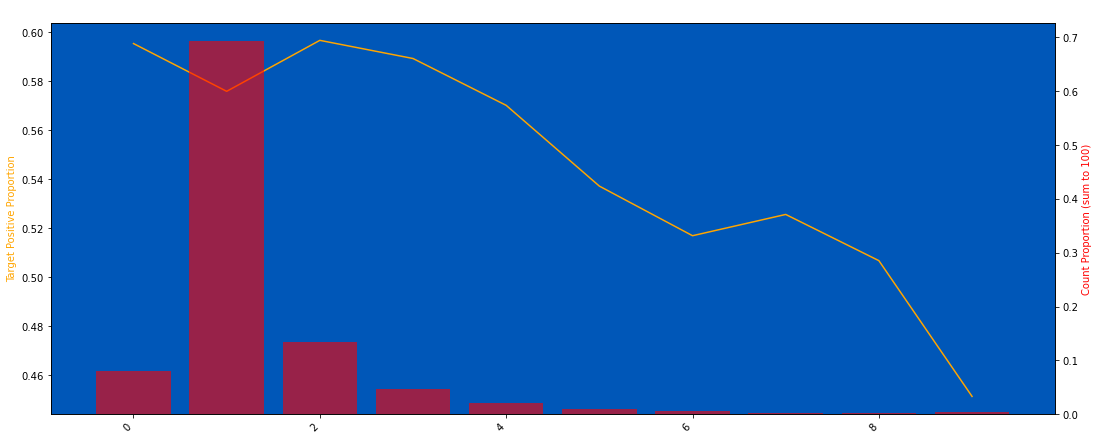

In [23]:
plot_target_check(train, "R_9", q=50, use_raw_bin=True)

### R_10

0 null count, 0.000 null proportion
nan of the targets have label = 1


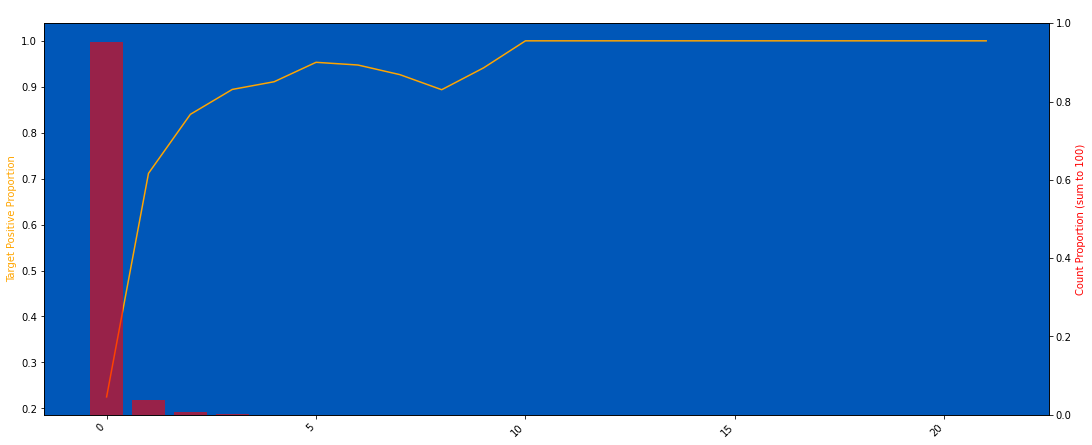

In [24]:
plot_target_check(train, "R_10", q=50, use_raw_bin=True)

### R_11

0 null count, 0.000 null proportion
nan of the targets have label = 1


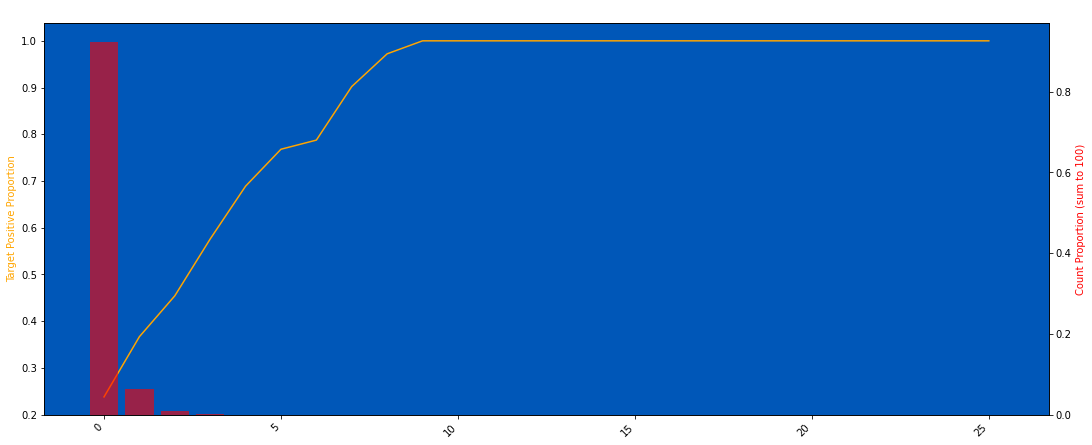

In [25]:
plot_target_check(train, "R_11", q=50, use_raw_bin=True)

### R_12

56 null count, 0.000 null proportion
0.2500 of the targets have label = 1


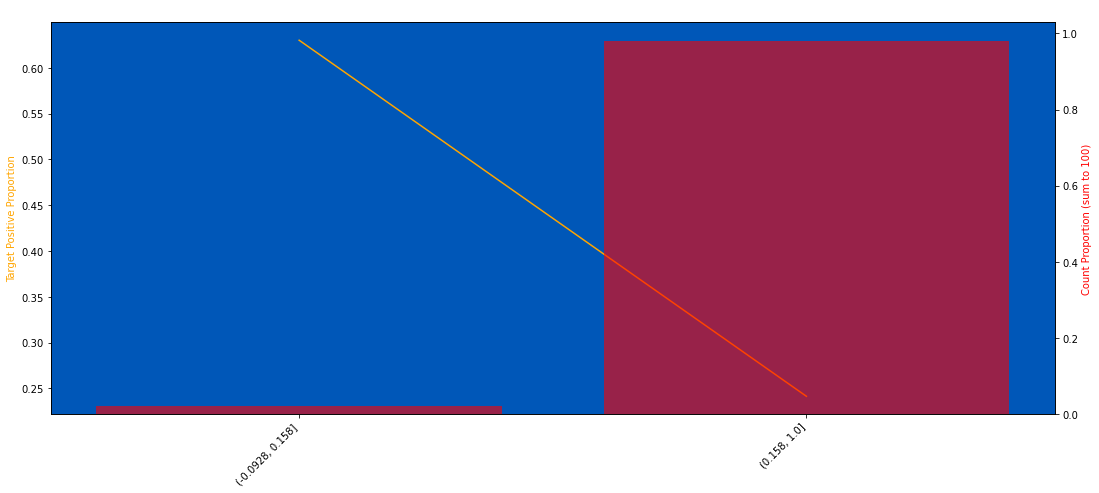

In [26]:
plot_target_check(train, "R_12", q=50, use_raw_bin=True)

### R_13

0 null count, 0.000 null proportion
nan of the targets have label = 1


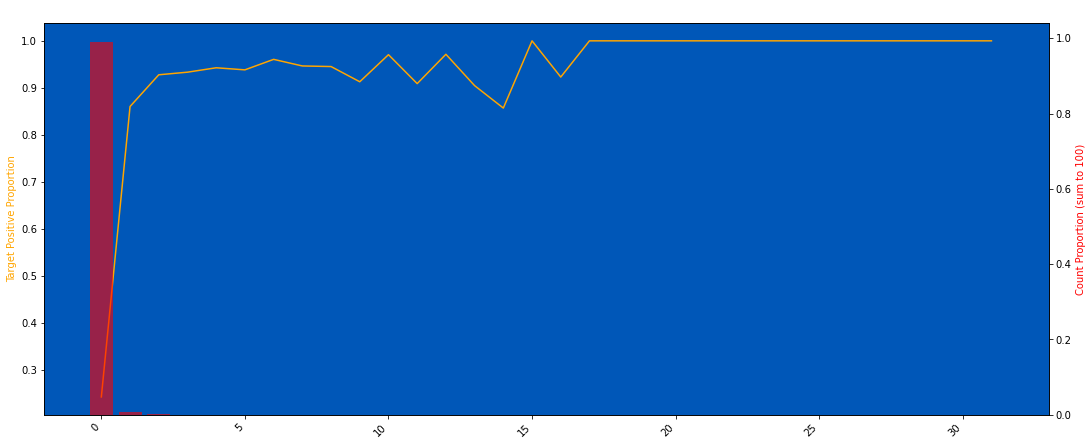

In [27]:
plot_target_check(train, "R_13", q=50, use_raw_bin=True)

### R_14

1 null count, 0.000 null proportion
1.0000 of the targets have label = 1


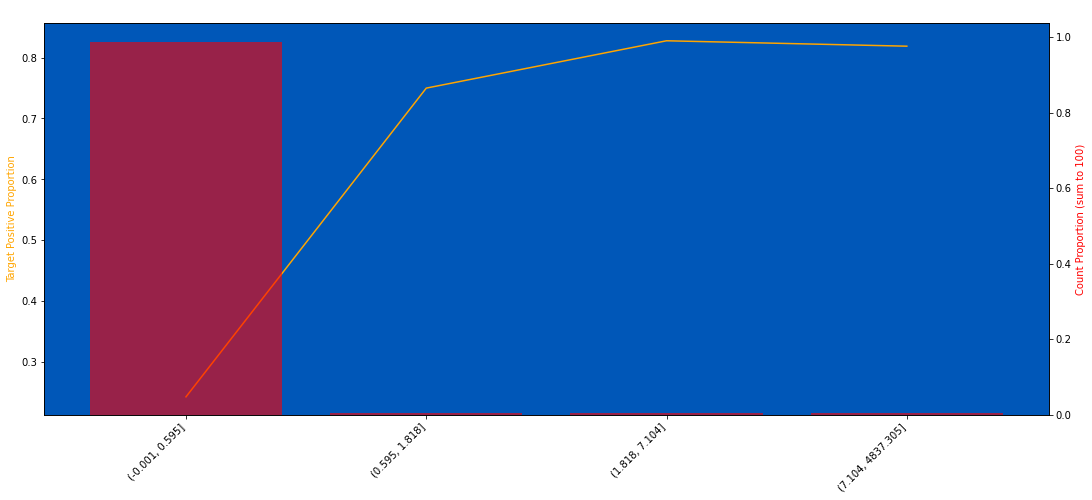

In [28]:
plot_target_check(train, "R_14", q=250, use_raw_bin=True)

### R_15

0 null count, 0.000 null proportion
nan of the targets have label = 1


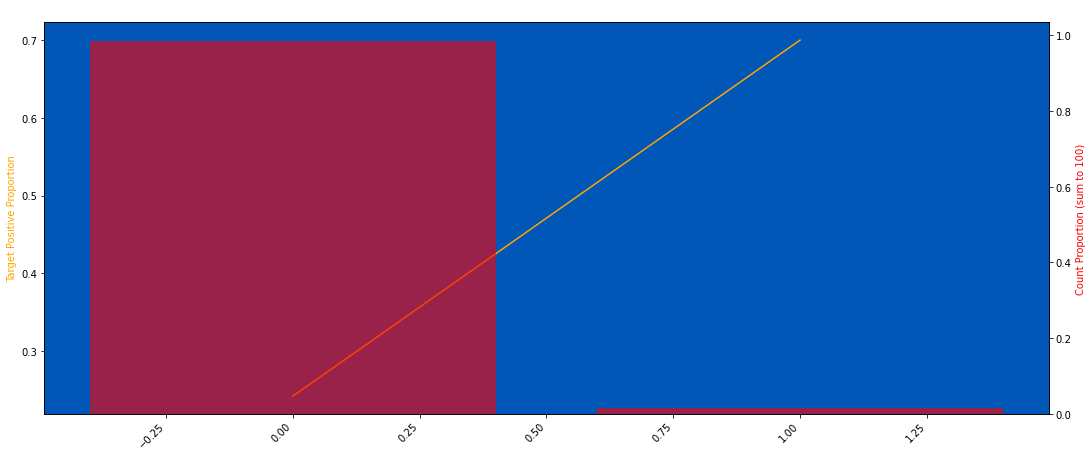

In [29]:
plot_target_check(train, "R_15", q=50, use_raw_bin=True)

### R_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


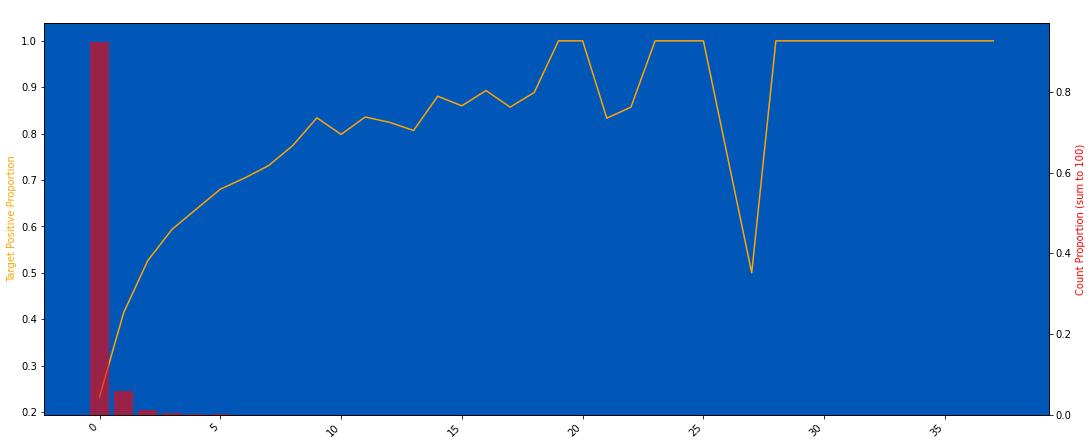

In [30]:
plot_target_check(train, "R_16", q=50, use_raw_bin=True)

### R_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


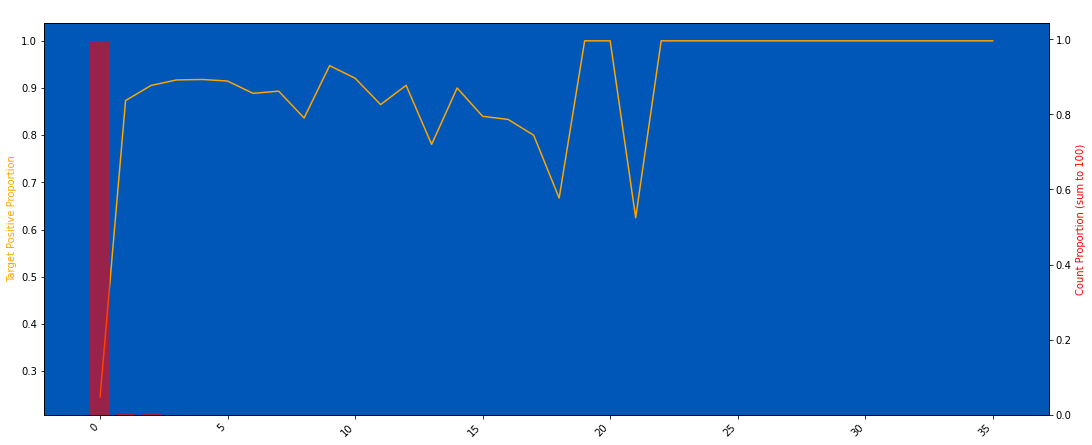

In [31]:
plot_target_check(train, "R_17", q=50, use_raw_bin=True)

### R_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


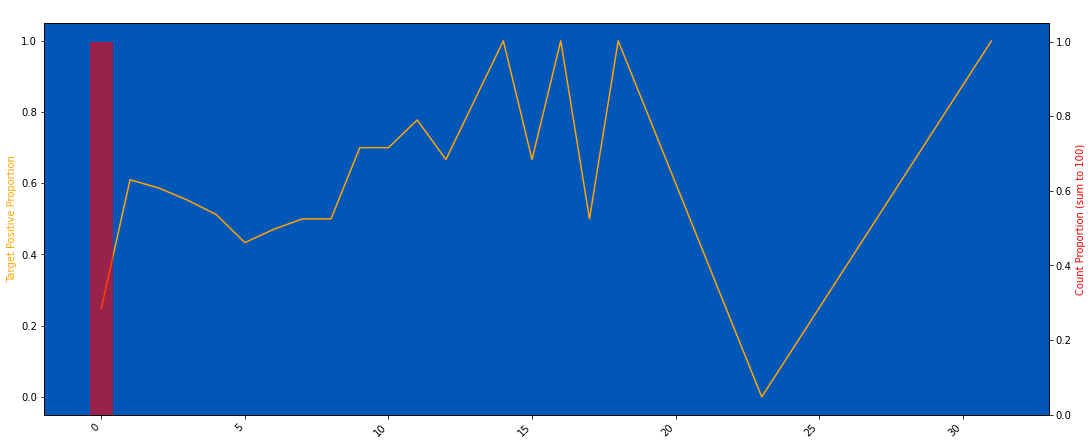

In [32]:
plot_target_check(train, "R_18", q=50, use_raw_bin=True)

### R_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


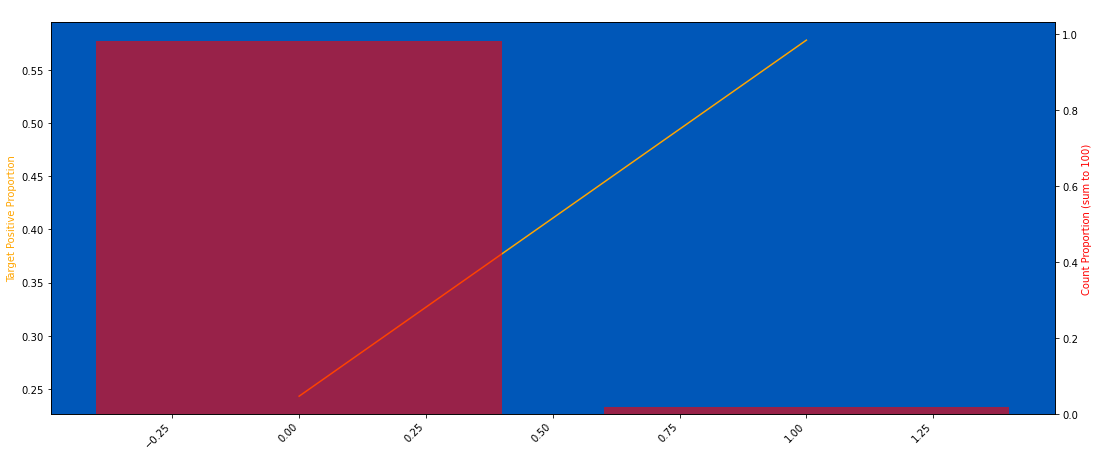

In [33]:
plot_target_check(train, "R_19", q=50, use_raw_bin=True)

### R_20

75 null count, 0.000 null proportion
0.2667 of the targets have label = 1


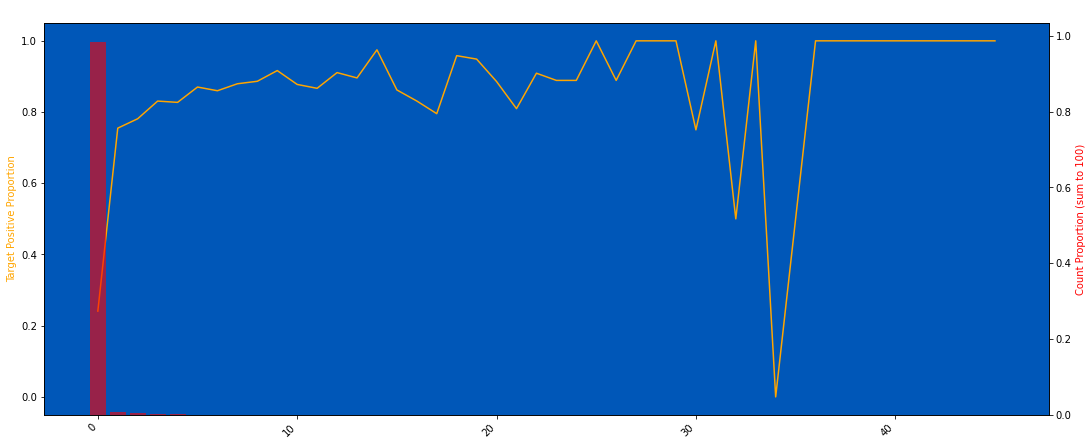

In [34]:
plot_target_check(train, "R_20", q=50, use_raw_bin=True)

### R_21

0 null count, 0.000 null proportion
nan of the targets have label = 1


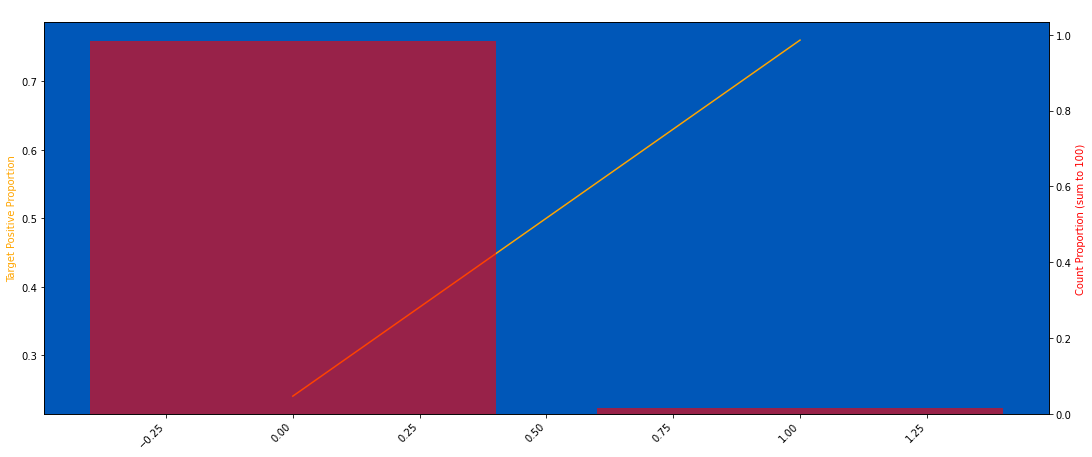

In [35]:
plot_target_check(train, "R_21", q=50, use_raw_bin=True)

### R_22

0 null count, 0.000 null proportion
nan of the targets have label = 1


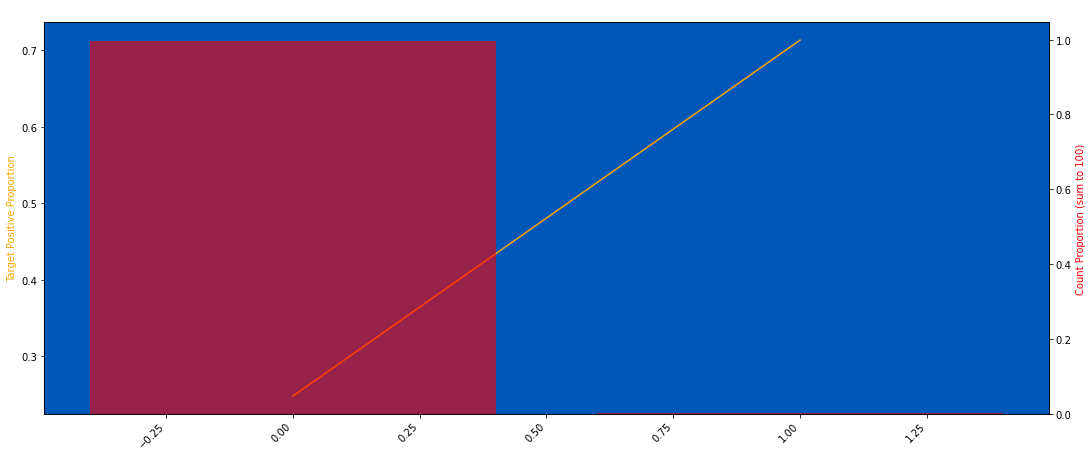

In [36]:
plot_target_check(train, "R_22", q=50, use_raw_bin=True)

### R_23

0 null count, 0.000 null proportion
nan of the targets have label = 1


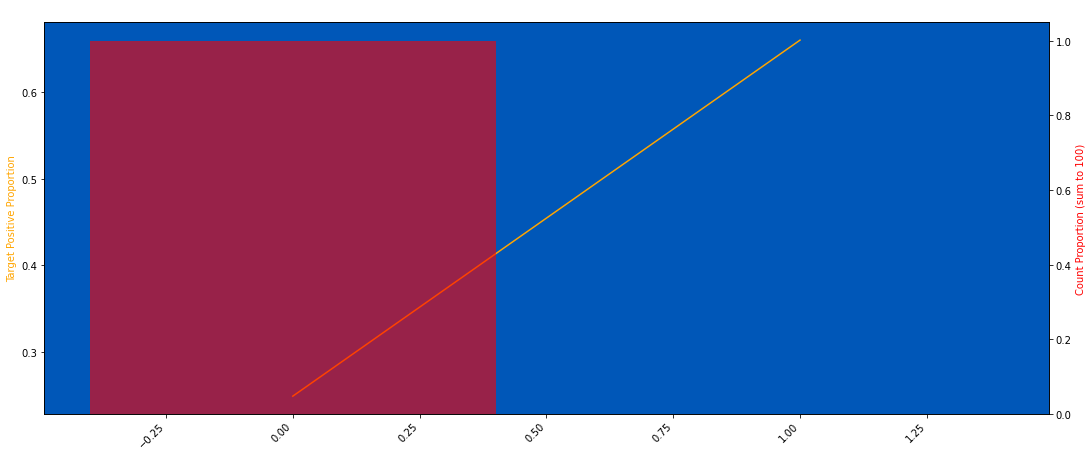

In [37]:
plot_target_check(train, "R_23", q=50, use_raw_bin=True)

### R_24

0 null count, 0.000 null proportion
nan of the targets have label = 1


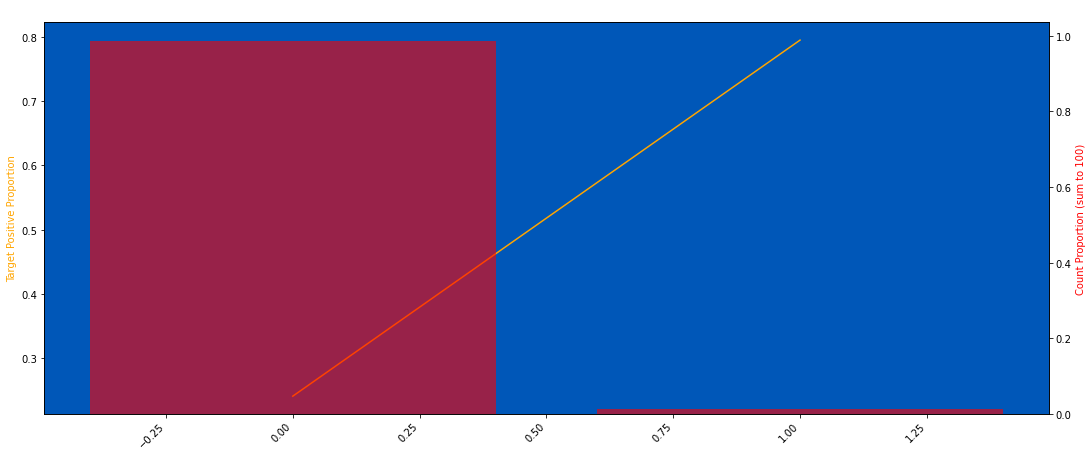

In [38]:
plot_target_check(train, "R_24", q=50, use_raw_bin=True)

### R_25

0 null count, 0.000 null proportion
nan of the targets have label = 1


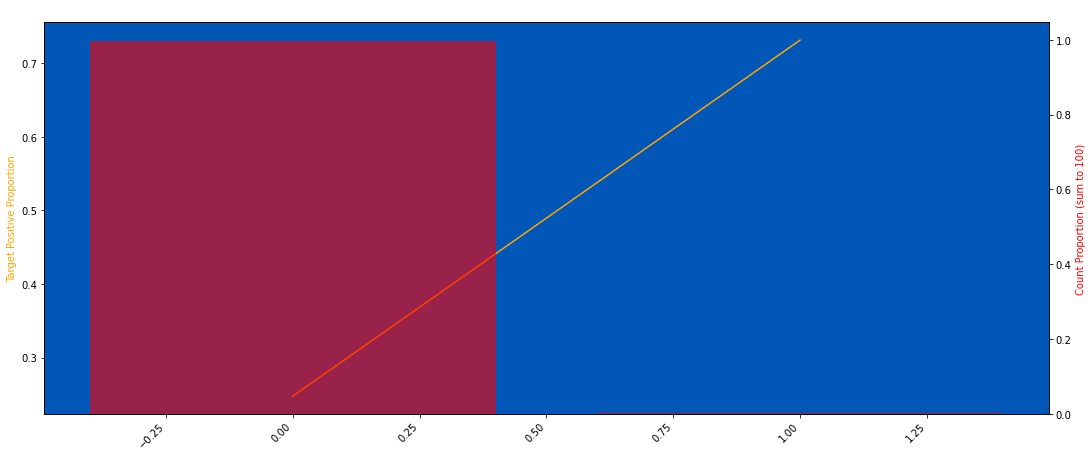

In [39]:
plot_target_check(train, "R_25", q=50, use_raw_bin=True)

### R_26

4922146 null count, 0.890 null proportion
0.2082 of the targets have label = 1


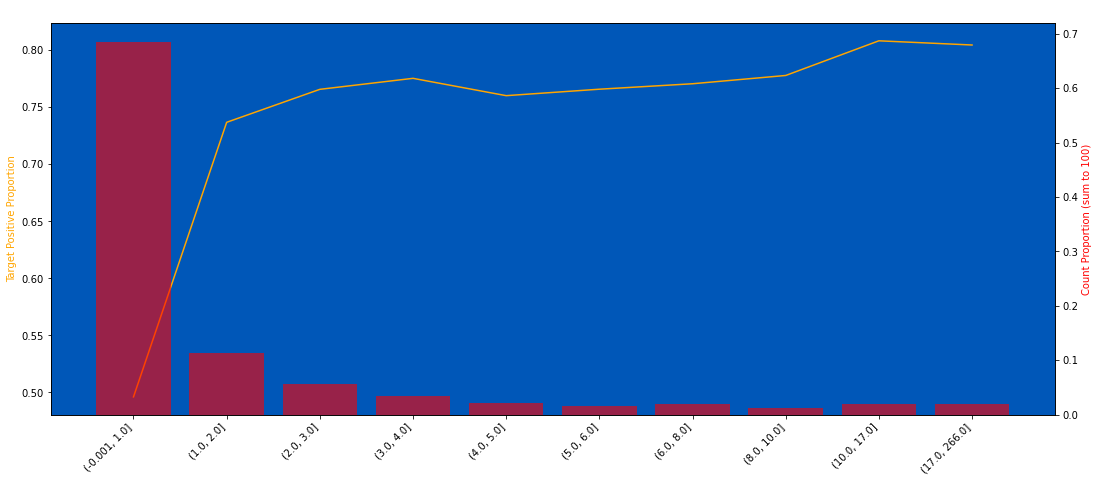

In [40]:
plot_target_check(train, "R_26", q=50, use_raw_bin=True)

### R_27

128703 null count, 0.023 null proportion
0.3361 of the targets have label = 1


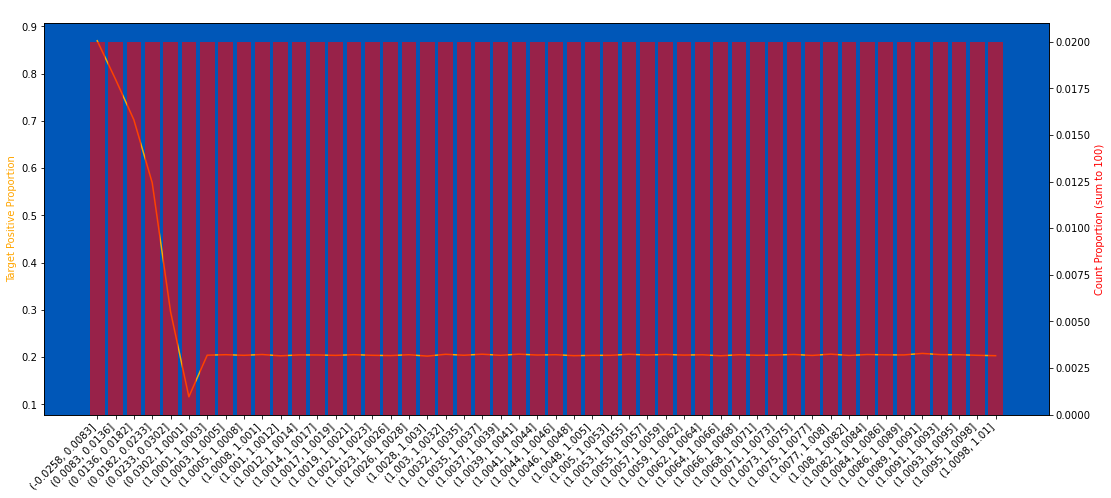

In [41]:
plot_target_check(train, "R_27", q=50, use_raw_bin=True)

In [42]:
train.loc[train["R_27"].between(1, 1.01), "R_27"] = 1
test.loc[test["R_27"].between(1, 1.01), "R_27"] = 1

In [43]:
train["R_27"] = train["R_27"].round(3)
test["R_27"] = test["R_27"].round(3)

128703 null count, 0.023 null proportion
0.3361 of the targets have label = 1


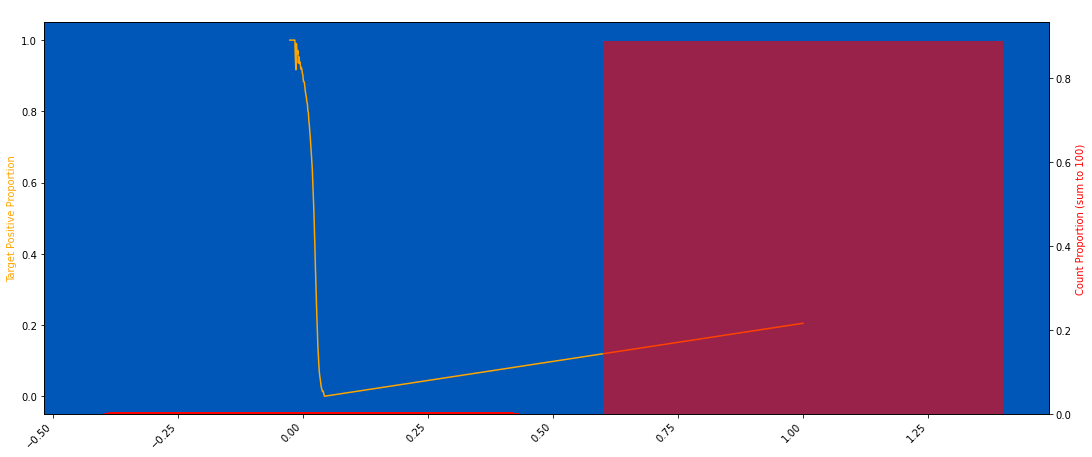

In [44]:
plot_target_check(train, "R_27", q=50, use_raw_bin=True)

### R_28

0 null count, 0.000 null proportion
nan of the targets have label = 1


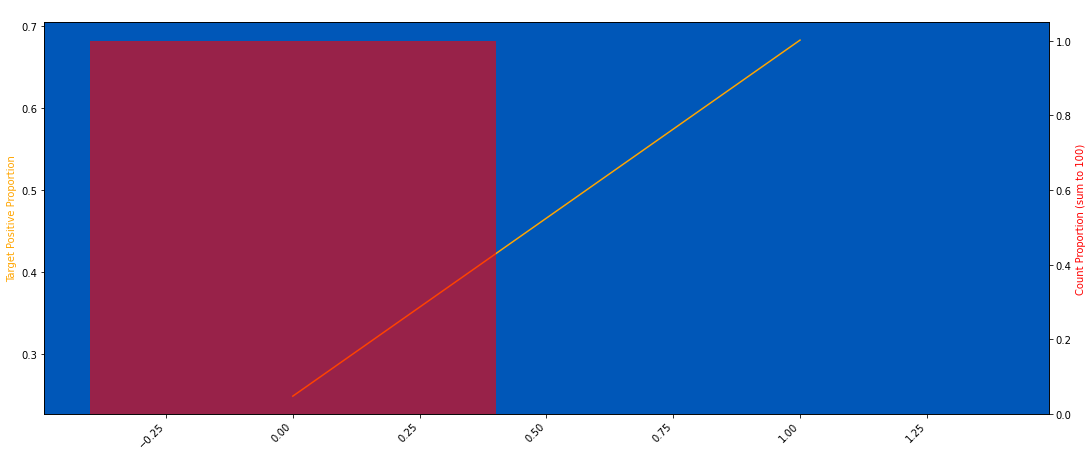

In [45]:
plot_target_check(train, "R_28", q=50, use_raw_bin=True)

### Column checking

In [47]:
from tqdm import tqdm

In [48]:
all_columns = get_cols(train, ["R_"])

In [49]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -0.99)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -0.99)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 94.69it/s]


In [50]:
d_col_nunique = train[all_columns].nunique()

In [51]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 50].index.tolist()

In [52]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

R_2 : int8 
 [0, 1] 

R_4 : int8 
 [0, 1] 

R_5 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 47, 48, 61, 70] 

R_8 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 33, 34, 38] 

R_9 : float64 
 [nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0] 

R_10 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 21] 

R_11 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 20, 21, 22, 25] 

R_13 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 31] 

R_15 : int8 
 [0, 1] 

R_16 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 35, 37] 

R_17 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 35] 

R_18

In [53]:
for col in tqdm(less_unique_d_cols):
    train[col] = integerize(train[col])
    test[col] = integerize(test[col])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.91it/s]


In [54]:
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

In [55]:
train.shape, test.shape

((5531451, 189), (11363762, 188))

In [56]:
%%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_bdpsr.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_bdpsr.parquet")

CPU times: user 48.3 s, sys: 8.93 s, total: 57.3 s
Wall time: 50.5 s


### Check Column

In [ ]:
(train["D_106"].round(1) - train["D_106"]).fillna(0).sum()